## **IV. Analysis summary**

- Summary of work undertaken in each code I to IIIb & noting of relevant analysis tables & plots available in each for report write up
- Ad-hoc analysis required for report write up such as:
  - Summary plots on performance of best models versus baseline model
  - Calibration analysis on best models

### **Contents**

1. Set up packages & drives
2. User-defined functions
3. Summary of work undertaken
4. Table summaries of fidelity performance of synthetic data across different augmentation scenarios

 4.1. Optimised CTGAN data - Class 0 ('non-bladder cancer')\
 4.2. Optimised CTGAN data - Class 1 ('bladder cancer')\
 4.3. Non-optimised CTGAN - Class 0 ('non-bladder cancer')\
 4.4. Non-optimised CTGAN - Class 1 ('bladder cancer')
5. Table & plot summaries of model performance by different augmentation scenarios & modelling methods

 5.1. All features with default hypers & RFE best features with default hypers\
 5.2. RFE best features with random search hypers\
 5.3. GA features with default hypers & GA features with GA hypers\
 5.4. Performance summary for all models by augmentation scenario & modelling method
6. Deep dive into best models

 6.1. PR & ROC curves for all methodologies\
 6.2. Feature importance scores for best models\
 6.3. Feature correlations - real vs. augmented
  - Calculate Euclidean distance between the correlation matrices for both classes

 6.4. Probability score threshold analysis

 6.5. Calibration analysis

  - Create calibration plots
  - Show changes in distribution of probability scores post-calibration
  - Recalculate threshold- variant performance metrics

   


### **1. Set up packages & drives**

In [ ]:
!pip install deap
!pip install pyforest
!pip install lazypredict

In [2]:
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
from numpy import argmax,sqrt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import make_scorer,accuracy_score,precision_score,precision_recall_curve,recall_score,f1_score,confusion_matrix,auc,roc_curve,accuracy_score,roc_auc_score,average_precision_score,log_loss,brier_score_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV,cross_val_score
import seaborn as sns
import time
import random
from scipy.stats import randint,uniform
from sklearn.feature_selection import RFE
import pickle
from deap import base, creator, tools, algorithms
from matplotlib.lines import Line2D
from scipy.spatial import distance
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import pyforest
import lazypredict
from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### **2. User-defined functions**

In [4]:
########## Gather together the fidelity performance metrics from each augmentation scenario ##########

def get_fidelity_metrics(df,col,scenario_name):
  min_idx=df[col].idxmin()
  min_row=df.loc[min_idx]
  df=min_row.to_frame(name=scenario_name).reset_index().rename(columns={'index':'Metric'}).iloc[1:,:]
  df[scenario_name]=df[scenario_name].apply(lambda x: round(float(x), 2))
  replace_dic={'pcd_0':'PCD score', 'mmd_0':'MMD score', 'kld_0':'KLD score','tot_num_0':'Total PCD, MMD, KLD', 'gen_0':'Gender distn', 'hyp_0':'Hypertension distn', 'dia_0':'Diabetes distn', 'smo_0':'Smoking distn', 'dri_0':'Drinking distn', 'bee_0':'Bee1leNu1 distn',
               'tot_cat_0':'Total Gender-Bee1leNu1', 'tot_0':'Total score',}
  df['Metric']=df['Metric'].replace(replace_dic)
  return df

########## Data preparation #########

def data_prep(model_name,train,test):

  ##### Get data #####

  train_df=pd.read_pickle(train)
  test_df=pd.read_pickle(test)

  ##### Standardize data #####

  # Training

  # Get all numeric features for standardization
  features=train_df.drop(['disease1','type'],axis=1)
  # Standardize numeric features
  scaler=MinMaxScaler()
  scaler.fit(features)
  features_std=scaler.transform(features)
  # Combine the standardized features with the target feature
  features_std=pd.DataFrame(features_std, columns=features.columns)
  features_std['disease1']=train_df['disease1']
  train=features_std
  # Make target feature numeric
  train['disease1']=train['disease1'].astype('int64')

  # Test

  test_features=test_df.drop('disease1',axis=1)
  # Standardize numeric features
  test_features_std=scaler.transform(test_features)
  # Combine the scaled features with the target feature
  test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
  test_features_std['disease1']=test_df['disease1']
  test=test_features_std
  # Make target feature numeric
  test['disease1']=test['disease1'].astype('int64')

  ##### Split features and labels for model build #####

  x_train=train.drop(['disease1'],axis=1)
  y_train=train['disease1']
  x_test=test.drop(['disease1'],axis=1)
  y_test=test['disease1']

  ##### Check datasets #####

  train_samples=x_train.shape[0]
  train_labels=y_train.shape[0]
  test_samples=x_test.shape[0]
  test_labels=y_test.shape[0]
  all_samples=train_samples+test_samples
  all_labels=train_labels+test_labels
  sizing_dic={model_name:{'train_samples':train_samples,
                          'train_labels':train_labels,
                          'test_samples':test_samples,
                          'test_labels':test_labels,
                          'all_samples':all_samples,
                          'all_labels':all_labels}}

  sizing_df=pd.DataFrame.from_dict(sizing_dic,orient='index')


  return(x_train,y_train,x_test,y_test,sizing_df)

########## Custom model evaluation function ##########

def pr_auc_eval(y_true,y_pred):
    precision,recall,_=precision_recall_curve(y_true, y_pred)
    pr_auc=auc(recall,precision)
    return pr_auc

########## Calculate F1-scores (array) from precision & recall arrays #########

def f1_scores_array(precision, recall):
    # Ensure the arrays are of same length
    assert len(precision)==len(recall), "Arrays must have same length"
    # Set up scores array with default value of 0
    f1_scores=np.zeros(len(precision))
    # Calculate score for each pair of precision & recall values
    for i in range(len(precision)):
        if precision[i]==0 and recall[i]==0:
            f1_scores[i]=0
        else:
            f1_scores[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])
    return f1_scores

########## Model evaluation ###########

def model_eval(model_name, y_test, y_pred, y_class, feat_names, feat_imp, valid_score, assign_method=None):

  ##### Consider alternative methods for determining optimal threshold cut-off #####

  # Balancing recall & precision - APPEARS TO CLASSIFY ALL CLASSES AS POSITIVE CLASS - DO NOT USE

  if assign_method=='pr':
    precision0, recall0, thresholds=precision_recall_curve(y_test,y_pred)
    f1_scores=f1_scores_array(precision0, recall0)
    # Get optimal threshold
    idx=np.argmax(f1_scores)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Balancing sensitivity & specificity

  elif assign_method=='ss':
    fpr0, tpr0, thresholds=roc_curve(y_test,y_pred)
    gmeans=np.sqrt(tpr0*(1-fpr0))
    idx=np.argmax(gmeans)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Maximum probability score - default method when no argument included in function call
  else:
     y_class

  ##### Performance metrics on test data #####

  logloss=log_loss(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_class)
  recall=recall_score(y_test,y_class)
  precision=precision_score(y_test,y_class)
  tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
  specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
  f1=f1_score(y_test,y_class)
  pr_auc=average_precision_score(y_test,y_pred)
  roc_auc=roc_auc_score(y_test,y_pred)
  fpr,tpr,_=roc_curve(y_test,y_pred)

  metrics_dic={model_name:{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':valid_score}}
  metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

  ##### Feature importance scores #####

  feat_imp_df=pd.DataFrame({'feature':feat_names,'importance':feat_imp})
  feat_imp_df=feat_imp_df.sort_values(by='importance',ascending=False)
  feat_imp_df[model_name]=round(feat_imp_df['importance'].rank(ascending=False),0)
  feat_imp_df.sort_values('feature',ascending=True,inplace=True)
  feat_imp_df.drop(columns=['importance'],axis=1,inplace=True)
  feat_imp_df=feat_imp_df.reset_index(drop=True)

  ##### PR & ROC curve data (threshold invariant) #####

  # PR curve
  precision1,recall1,thresholds=precision_recall_curve(y_test,y_pred)
  random_model=len(y_test[y_test==1])/len(y_test)
  pr_curve_dic={model_name:{'precision':precision1,
                            'recall':recall1,
                            'random_model':random_model,
                            'pr_auc':pr_auc}}
  #pr_curve_df=pd.DataFrame.from_dict(pr_curve_dic,orient='index')

  # ROC curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_dic={model_name:{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}
  #roc_curve_df=pd.DataFrame.from_dict(roc_curve_dic,orient='index')

  return metrics_df, feat_imp_df, pr_curve_dic, roc_curve_dic

########## Feature ranks heatmap ##########

def feat_map(title):

  # Get data
  feat_imp_all = pd.concat([feat_imp_bal, feat_imp_25, feat_imp_50, feat_imp_100, feat_imp_250, feat_imp_500, feat_imp_1000], axis=1).iloc[:,[0,1,3,5,7,9,11,13]].sort_values(by='_bal').reset_index(drop=True)

  # Categorising of values e.g. values 1, 2, 3, 4, 5 are set to 5
  def replace_values(value):
      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:30, 22:30, 23:30, 24:30, 25:30,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:36, 32:36, 33:36, 34:36, 35:36,
                          36:36}
      return replacement_values.get(value,value)

  df1 = feat_imp_all.applymap(replace_values)

  # Reshape for heatmap
  melt_df1 = pd.melt(df1, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  custom_model_order=['_bal','_25','_50','lgbm_100','_250','_500','_1000']

  # Convert 'Model' column to Categorical with custom order
  melt_df1['Model'] = pd.Categorical(melt_df1['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  melt_df1 = melt_df1.sort_values(by=['feature','Model'])
  melt_df1.rename(columns={'feature':'Feature'}, inplace=True)
  heatmap_data=melt_df1.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  plt.figure(figsize=(12,8))
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False)
  plt.title('Feature importance ranks by model' + '\n' + title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  plt.show()

  return

########## Feature ranks heatmap (version 2) ##########

def feat_heatmap(df, title, x, y, opt_flag=None):
  # Flag informs the function if the CTGAN was optimised or not

  # Sort data
  df1=df.sort_values(by=df.columns[0]).reset_index(drop=True)

  # Replace NaN with 99 (='not used by model')
  df2=df1.fillna(99)

  # Group the ranks for easier interpretation e.g. values 1, 2, 3, 4, 5 are set to 5

  def replace_values(value):

      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:25, 22:25, 23:25, 24:25, 25:25,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:35, 32:35, 33:35, 34:35, 35:35,
                          36:40,
                          99:99}

      return replacement_values.get(value,value)

  df3=df2.applymap(replace_values)

  # Reshape data for heatmap
  df4=pd.melt(df3, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  if opt_flag==1:
    custom_model_order=['_25_o','_50_o','_100_o','_250_o','_500_o','_1000_o']
  else:
    custom_model_order=['_bal','_25','_50','_100','_250','_500','_1000']

  # Convert 'Model' column to categorical with custom order
  df4['Model']=pd.Categorical(df4['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  df5=df4.sort_values(by=['feature','Model'])
  df5.rename(columns={'feature':'Feature'}, inplace=True)

  heatmap_data=df5.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False, ax=axes[x, y])
  heatmap.set_title(title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  return

########## Plotting PR & ROC curves (version 1) ##########

def auc_curves2(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'GA feats & default hypers - AUC={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'GA feats & GA hypers - AUC={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='lower right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'GA feats & default hypers - AUC={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'GA feats & GA hypers - AUC={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

########## Plotting PR & ROC curves (version 2) ##########

def auc_curves3(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'Non-optimised data - AUC={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'Optimised data - AUC={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='lower right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'Non-optimised data - AUC={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'Optimised data - AUC={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

########### Plot heatmap of Spearman rank scores ###########

def heatmap_plot(df,title,pos1,pos2,annot_size):
  sns.heatmap(df,linewidth=0.5,annot=True,annot_kws={"size":annot_size},fmt='.1f',vmin=-1,vmax=1,center=0,square=True,cmap='coolwarm',cbar_kws={"shrink":0.83},ax=axes[pos1,pos2])
  axes[pos1,pos2].set_title(title,pad=30,fontsize=45)
  #axes[pos1,pos2].tick_params(axis='y',labelsize=32)
  axes[pos1,pos2].set_xticklabels(axes[pos1,pos2].get_xmajorticklabels(),fontsize=36,rotation=45,horizontalalignment='right')
  axes[pos1,pos2].set_yticklabels(axes[pos1,pos2].get_ymajorticklabels(),fontsize=36,rotation=0,horizontalalignment='right')
  cbar=axes[pos1, pos2].collections[0].colorbar
  cbar.ax.tick_params(labelsize=36)
  return

########## Build LGBM model using provided features and hyperparameters ##########

def build_model(hypers, feats, x_train, y_train, x_test):

  # Instantiate classifier with GA selected hyperparameters
  model=lgb.LGBMClassifier(**hypers)
  model.set_params(verbose=-1)

  # Use cross-validation to check model performance on GA selected features
  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores=cross_val_score(model, x_train[feats], y_train, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))

  # Train model on full training data
  clf=model.fit(x_train[feats], y_train)

  # Get prediction probabilities & class assignments (maximum probability scores) for test data
  y_pred=clf.predict_proba(x_test[feats])[:, 1]

  return y_pred

########## Generate performance metrics based on 1,000 threshold cut-offs inbetween 0 and 1 ##########

def perf_metrics(y_pred,y_test):

  # Initialize lists to store metric values
  thresholds=np.arange(0, 1.001, 0.001)
  metrics_dic={'threshold':thresholds,'recall':[],'precision':[],'specificity':[],'f1':[],'accuracy':[],'pr_auc':[],'roc_auc':[]}

  for threshold in thresholds:
      # Assign class to each test sample based on threshold cut-off
      y_class=(y_pred>threshold).astype(int)

      # Calculate threshold variant performance metrics
      tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
      recall=tp/(tp+fn) if (tp+fn)>0 else 0
      precision=tp/(tp+fp) if (tp+fp) >0 else 0
      specificity=tn/(tn+fp) if (tn+fp)>0 else 0
      f1=2*(precision*recall)/(precision+recall) if (precision+recall)>0 else 0
      accuracy=(tp+tn)/(tp+tn+fp+fn) if (tp+tn+fp+fn)>0 else 0

      # Calculate pr-auc (threshold invariant)
      precision1,recall1,_=precision_recall_curve(y_test,y_pred)
      pr_auc=auc(recall1,precision1)

      # Calculate roc-auc (threshold invariant)
      fpr,tpr,_=roc_curve(y_test,y_pred)
      roc_auc=auc(fpr,tpr)

      # Add metric values to dic
      metrics_dic['recall'].append(recall)
      metrics_dic['precision'].append(precision)
      metrics_dic['specificity'].append(specificity)
      metrics_dic['f1'].append(f1)
      metrics_dic['accuracy'].append(accuracy)
      metrics_dic['pr_auc'].append(pr_auc)
      metrics_dic['roc_auc'].append(roc_auc)

  # Convert dic into df
  metrics_df=pd.DataFrame(metrics_dic)

  return metrics_df

########## Calculate Euclidean distance between two matrices ##########

def euclidean_distance(matrix1, matrix2):
    # Flatten the matrices
    array1=matrix1.to_numpy()
    array2=matrix2.to_numpy()
    # Calculate Euclidean distance
    eucl_dist=np.linalg.norm(array1-array2)
    return eucl_dist

########## Find Euclidean distance between any numeric row (array) in a df and a given data point (of same dimension as df) ##########

def euclidean_distance1(row, given_point):
    return distance.euclidean(row, given_point)

########## Find Euclidean distances between all respective pairs of numeric rows in two dfs (of same dimension) ##########

def euclidean_distance2(df1, df2):
    # Assuming df1 and df2 are DataFrames with numeric values
    array1 = df1.values
    array2 = df2.values
    # Calculate the Euclidean distance for each pair of corresponding points
    distances = np.linalg.norm(array1 - array2, axis=1)
    return distances

########## Subset df by selecting rows where the 'threshold' column has certain set values ##########

def get_threshold_methods(row):
    methods = []
    if row['threshold'] == max_prob_threshold:
        methods.append('max prob score')
    if row['threshold'] == prior_prob_threshold:
        methods.append('prior pop prob')
    if row['threshold'] == pr_opt_threshold:
        methods.append('closest pt on pr curve to [1,1]')
    if row['threshold'] == roc_opt_threshold:
        methods.append('closest pt on roc curve to [0,1]')
    if row['threshold'] == max_f1_threshold:
        methods.append('maximise f1 score')
    if row['threshold'] == ss_bal_threshold:
        methods.append('balance sensitivity & specificity')
    if row['threshold'] == tsai_threshold:
        methods.append('perf metrics similarity - tsai')
    if row['threshold'] == shih_threshold:
        methods.append('perf metrics similarity - shih')
    return tuple(methods) if methods else ('None',)

########## Function to format y-axis ticks as percentages ##########

def percentage_formatter(x, pos):
    return f'{x:.0%}'

### **3. Summary of work undertaken**

**I. Data preprocessing**
 - Class breakdown - how rare is event of interest? Level of class imbalance?
 - Level of missing values incl. differences by class
 - Distribution of values by feature - Any skewed? Any nearly constant?
 - Distribution of values by feature & class - are the classes similar?
 - Pairwise correlations for continuous features (Spearman Ranks monotonicity) - how do the features relate to each other - all together and by class?
 - Are there linear relationships between features and target?

**IIa. Data augmentation CTGAN - Default hyperparameters**
 - Generate synthetic samples separately for each class
 - Note that raw data had to be transformed so that the generator did not produce negative values
 - Loss metrics for CTGAN generator & discriminator over epochs for each class & size of synthetic dataset (have summary plots)
 - Fidelity metrics (PCD, MMD, KLD, categorical feature distributions) by class & size of synthetic dataset (have summary)
 - Stability of CTGANs to produce synthetic data of same fidelity for multiple runs (5) (using same hyperparameters) for each size of synthetic dataset (have summary tables for each scenario & coefficient of variation radar plot summary comprising all scenarios)
 - Feature distribution analysis - real versus synthetic (have plots whereby each plot shows the distribution of the real data vs. the distribution of the synthetic data for each augmentation scenario)
 - Feature correlations (Spearman ranks) of real data versus that of the synthetic data in each augmented dataset scenario

**IIb. Data augmentation CTGAN - Optimised hyperparameters**
 - Grid search used to find best hypers for CTGAN for each augmentation scenario. For every combination of hypers all the fidelity metrics (numeric and categorical) were calculated and their grand sum taken as the overall performance score. The hypers generating the dataset with the lowest performance score were taken forward into creating the augemented dataset

 The rest follows the same as per IIc.:

 - Loss metrics for CTGAN generator & discriminator over epochs for each class & size of best synthetic dataset (have summary plots). LOSS RATES SMALLER FOR GENERATOR THAN FOR IIa BUT HIGHER FOR DISCRIMINATOR
 - Fidelity metrics (PCD, MMD, KLD, categorical feature distributions) by class & size of best synthetic dataset (have summary). BETTER RESULTS THAN FOR IIa.
 - Stability of CTGANs to produce synthetic data of same fidelity for multiple runs (5) (using same best hyperparameters per scenario) for each size of synthetic dataset (have summary tables for each class & coefficient of variation radar plot summary comprising all scenarios). PERFORMANCE NOT BETTER NOR WORSE THAN THAT OF IIa.
 - Feature distribution analysis - real versus synthetic (have plots whereby each plot shows the distribution of the real data vs. the distribution of the synthetic data for each augmentation scenario). BETTER RESULTS THAN FOR IIa.
 - Feature correlations (Spearman ranks) of real data versus that of the synthetic data in each augmented dataset scenario
 - Euclidean distances between feature correlation matrices - real class 0 vs. synthetic class 0 (+25%, +50%,...) (have summary table). BETTER RESULTS THAN FOR IIa.

**IIIa. Classification models - LGBM - Non-GA**

- Augmentation training data is standardized
- (1) Subset features - all features - default hypers - optimised CTGAN data - non-optimised CTGAN data:
 - RFE wrapper used with LGBM classifer (default hypers) on each augmentation scenario to get a best feature subset. Performance evaluation is PR-AUC. Did not use CV due to computational cost. While the evaluation focus is on threshold invariant metrics (PR/ROC-AUC) exploratory work showed that the derivation of threshold-based performance metrics is more robust and reliable using the threshold which balances sensitivity and specificity ('ss'). Thresholds based on balancing precision and recall or 0.5 showed inconsistent performance which are most probably due to the distribution and spread of probability scores produced by the models
 - Get summary tables for model performances using subset feats/all feats/optimised CTGAN data/non-optimised CTGAN data
 - FEATURE SUBSETS MODELS OUT-PERFORMED ALL FEATURE MODEL. NOT CLEARCUT FOR OPTIMISED VS NON-OPTIMISED CTGAN DATA
 - Compared feature ranks in each model by scenario
- (2) Subset features - RS hypers - optimised CTGAN data - non-optimised CTGAN data:
 - RFE feature subsets from above considerd
 - RS over grid defined around default values (still challenging for search algorithm)
 - RS involved stratified 5-fold CV and 10,000 randomly chosen hyperparameter combinations per fold (50,000 combos per model)
 - PR-AUC for evaluating hyperparameter combinations per fold
 - Have summary tables of model performance per augmentation scenario & optimised data slightly better PR-AUC. ROC not so great for either
 - Reviewed feature importance ranks

**IIIb. Classification models - LGBM - GA**
- Used API DEAP to develop GA searches for best features and hyperparameters for each augmented dataset from non-optimised & optimised CTGAN models
- For GA hypers (selection, cross-over, mutation, population size, number of generations) was guided by literature. Did not try variation of these
- GA considers the same grid space as that of Randomised search for hyper selection
- Use custom PR-AUC function for all model performance evaluation
- Created models for:
  - GA feat subset selection & default hypers (optimised & non-optimised CTGAN data)
  - GA feat subset selection & GA hyper selection (optimised & non-optimised CTGAN data)
- Have GA fitness value scores per generations for each model (line plot)
- Have performance summary tables for each model SIGNIFICANTLY BETTER PERFORMANCE THAT FOR RFE & RS MODELS IN IIIa - FOR BOTH PR-AUC & ROC-AUC. AND SPECIFICALLY FOR GA, BETTER PERFORMANCE WHEN HYPERS ALSO OPTIMISED WITH GA - FOR BOTH PR-AUC & ROC-AUC & FOR OPTIMISED & NON-OPTIMISED
- Did feature rank plots

**Note: Baseline model for comparison purposes is an LGBM classifier using all features, default hyperparameters and balanced with synthetic data from a non-optimised CTGAN**

### **4. Table summaries of fidelity performance of synthetic data across different augmentation scenarios**



As noted above, can get tables & plots from IIA (non-optimised CTGAN) & IIB (optimised CTGAN) for:
- Variation in fidelity over repeated runs (have radar plots)
- Generator and discriminator loss rates by epoch
- Comparison of feature value distributions for real data versus synthetic data
- Feature correlation matrices
 - Real data vs synthetic data
 - Euclidean distances between respective matrices

FROM THE TWO TABLES BELOW CAN SEE THAT THE OPTIMISED CTGAN SYNTHETIC DATA SAMPLES PROVIDE BETTER FIDELITY FOR BOTH CLASSES (NON-BLADDER CANCER & BLADDER CANCER) THAN FOR NON-OPTIMISED CTGAN

#### **4.1. Class 0 ('non-bladder cancer') - Non-optimised CTGAN data**

In [ ]:
fid_0_bal=get_fidelity_metrics(df_0_bal,'tot_0','Bal')
fid_0_25=get_fidelity_metrics(df_0_25,'tot_0','+25%')
fid_0_50=get_fidelity_metrics(df_0_50,'tot_0','+50%')
fid_0_100=get_fidelity_metrics(df_0_100,'tot_0','+100%')
fid_0_250=get_fidelity_metrics(df_0_250,'tot_0','+250%')
fid_0_500=get_fidelity_metrics(df_0_500,'tot_0','+500%')
fid_0_1000=get_fidelity_metrics(df_0_1000,'tot_0','+1000%')
fid_0_all=pd.concat([fid_0_bal, fid_0_25['+25%'], fid_0_50['+50%'], fid_0_100['+100%'], fid_0_250['+250%'], fid_0_500['+500%'], fid_0_1000['+1000%']], axis=1)

In [ ]:
fid_0_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,PCD score,5.57,5.45,5.10,5.28,5.47,5.19,4.97
2,MMD score,0.65,0.63,0.93,0.51,0.82,0.61,0.70
3,KLD score,0.69,0.69,0.69,0.69,0.69,0.69,0.69
4,"Total PCD, MMD, KLD",6.92,6.77,6.72,6.48,6.97,6.49,6.37
5,Gender distn,0.12,0.16,0.28,0.23,0.13,0.31,0.42
6,Hypertension distn,0.14,0.15,0.16,0.16,0.36,0.18,0.24
7,Diabetes distn,0.22,0.31,0.13,0.08,0.07,0.06,0.01
8,Smoking distn,0.13,0.37,0.22,0.03,0.05,0.07,0.34
9,Drinking distn,0.13,0.03,0.01,0.11,0.08,0.12,0.30
10,Bee1leNu1 distn,0.09,0.07,0.08,0.08,0.12,0.09,0.11


#### **4.2. Class 0 ('non-bladder cancer') - Optimised CTGAN data**

In [ ]:
# Get datasets from IIA & IIB - need to import if wanting to use in further analysis
fid_0_bal=get_fidelity_metrics(df_0_bal,'tot_0','Bal')
fid_0_25=get_fidelity_metrics(df_0_25,'tot_0','+25%')
fid_0_50=get_fidelity_metrics(df_0_50,'tot_0','+50%')
fid_0_100=get_fidelity_metrics(df_0_100,'tot_0','+100%')
fid_0_250=get_fidelity_metrics(df_0_250,'tot_0','+250%')
fid_0_500=get_fidelity_metrics(df_0_500,'tot_0','+500%')
fid_0_1000=get_fidelity_metrics(df_0_1000,'tot_0','+1000%')
fid_0_all=pd.concat([fid_0_bal, fid_0_25['+25%'], fid_0_50['+50%'], fid_0_100['+100%'], fid_0_250['+250%'], fid_0_500['+500%'], fid_0_1000['+1000%']], axis=1)

In [ ]:
fid_0_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,PCD score,5.28,5.13,4.88,4.89,5.05,4.89,4.99
2,MMD score,0.19,0.18,0.15,0.49,0.40,0.48,0.22
3,KLD score,0.69,0.69,0.69,0.69,0.69,0.69,0.69
4,"Total PCD, MMD, KLD",6.16,6.00,5.72,6.07,6.15,6.06,5.90
5,Gender distn,0.01,0.05,0.01,0.13,0.01,0.02,0.03
6,Hypertension distn,0.05,0.02,0.07,0.02,0.02,0.00,0.07
7,Diabetes distn,0.06,0.02,0.21,0.06,0.02,0.01,0.10
8,Smoking distn,0.00,0.17,0.24,0.03,0.00,0.03,0.08
9,Drinking distn,0.16,0.00,0.17,0.01,0.01,0.04,0.05
10,Bee1leNu1 distn,0.08,0.02,0.10,0.01,0.04,0.01,0.09


#### **4.3. Class 1 ('bladder cancer') - Non-optimised CTGAN**

In [ ]:
fid_1_bal=get_fidelity_metrics(df_1_bal,'tot_1','Bal')
fid_1_25=get_fidelity_metrics(df_1_25,'tot_1','+25%')
fid_1_50=get_fidelity_metrics(df_1_50,'tot_1','+50%')
fid_1_100=get_fidelity_metrics(df_1_100,'tot_1','+100%')
fid_1_250=get_fidelity_metrics(df_1_250,'tot_1','+250%')
fid_1_500=get_fidelity_metrics(df_1_500,'tot_1','+500%')
fid_1_1000=get_fidelity_metrics(df_1_1000,'tot_1','+1000%')
fid_1_all=pd.concat([fid_1_bal, fid_1_25['+25%'], fid_1_50['+50%'], fid_1_100['+100%'], fid_1_250['+250%'], fid_1_500['+500%'], fid_1_1000['+1000%']], axis=1)

In [ ]:
fid_1_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,pcd_1,12.68,6.72,6.02,5.90,5.70,5.50,5.49
2,mmd_1,0.66,0.65,0.45,0.61,0.57,0.41,0.82
3,kld_1,0.69,0.69,0.70,0.69,0.69,0.69,0.69
4,tot_num_1,14.04,8.06,7.16,7.20,6.96,6.60,7.00
5,gen_1,0.07,0.25,0.11,0.29,0.40,0.07,0.05
6,hyp_1,0.22,0.21,0.38,0.24,0.22,0.05,0.19
7,dia_1,0.44,0.35,0.28,0.17,0.36,0.04,0.16
8,smo_1,0.04,0.24,0.18,0.18,0.14,0.34,0.46
9,dri_1,0.19,0.22,0.15,0.28,0.18,0.02,0.06
10,bee_1,0.16,0.05,0.22,0.19,0.17,0.35,0.14


#### **4.4. Class 1 ('bladder cancer') - Optimised CTGAN data**

In [ ]:
fid_1_bal=get_fidelity_metrics(df_1_bal,'tot_1','Bal')
fid_1_25=get_fidelity_metrics(df_1_25,'tot_1','+25%')
fid_1_50=get_fidelity_metrics(df_1_50,'tot_1','+50%')
fid_1_100=get_fidelity_metrics(df_1_100,'tot_1','+100%')
fid_1_250=get_fidelity_metrics(df_1_250,'tot_1','+250%')
fid_1_500=get_fidelity_metrics(df_1_500,'tot_1','+500%')
fid_1_1000=get_fidelity_metrics(df_1_1000,'tot_1','+1000%')
fid_1_all=pd.concat([fid_1_bal, fid_1_25['+25%'], fid_1_50['+50%'], fid_1_100['+100%'], fid_1_250['+250%'], fid_1_500['+500%'], fid_1_1000['+1000%']], axis=1)

In [ ]:
fid_1_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,pcd_1,10.90,6.20,5.67,5.70,5.49,5.54,5.43
2,mmd_1,0.09,0.07,0.24,0.09,0.11,0.06,0.08
3,kld_1,0.69,0.69,0.69,0.69,0.69,0.69,0.69
4,tot_num_1,11.69,6.97,6.60,6.48,6.29,6.29,6.21
5,gen_1,0.03,0.03,0.06,0.08,0.03,0.01,0.00
6,hyp_1,0.02,0.02,0.00,0.07,0.06,0.06,0.01
7,dia_1,0.14,0.08,0.08,0.04,0.07,0.05,0.02
8,smo_1,0.06,0.05,0.01,0.04,0.05,0.09,0.11
9,dri_1,0.19,0.12,0.07,0.03,0.03,0.04,0.02
10,bee_1,0.26,0.10,0.03,0.07,0.05,0.09,0.08


### **5. Table & plot summaries of model performance by different augmentation scenarios & modelling methods**

Just reference the tables in sections 5.1. to 5.3. and ignore the plots. The plots in 5.1. to 5.3 are summarised together in the plots of 5.4.

#### **5.1. All features/default hypers & RFE best features/default hypers**

Get metric summaries

In [ ]:
# CTGAN non-optimised

# All features & default hyperparameters
rfe_metrics_summary_all_feats1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats1.pkl')

# RFE features  & default hyperparameters
rfe_metrics_summary_best_model1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model1.pkl')

# CTGAN optimised

# All features & default hyperparameters
rfe_metrics_summary_all_feats_o1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_all_feats_o1.pkl')
new_index= {'_bal_o': '_bal', '_25_o': '_25', '_50_o': '_50', '_100_o': '_100', '_250_o': '_250', '_500_o': '_500', '_1000_o': '_1000'}
rfe_metrics_summary_all_feats_o1=rfe_metrics_summary_all_feats_o1.rename(index=new_index)

# RFE features  & default hyperparameters
rfe_metrics_summary_best_model_o1=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o1.pkl')
rfe_metrics_summary_best_model_o1=rfe_metrics_summary_best_model_o1.rename(index=new_index)

Review metric summaries

Non-optimised CTGAN data

In [ ]:
# Augmented datasets - non-optimised CTGAN - all features
rfe_metrics_summary_all_feats1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,138,26,21,73,0.657171,0.635659,0.654028,0.867925,0.553191,0.745946,0.871711,0.623172,36
_25,113,30,17,98,0.655725,0.554264,0.535545,0.869231,0.638298,0.662757,0.855559,0.615509,36
_50,159,26,21,52,0.609954,0.717054,0.753555,0.883333,0.553191,0.813299,0.875999,0.660280,36
_100,150,28,19,61,0.651120,0.689922,0.710900,0.887574,0.595745,0.789474,0.872016,0.636382,36
_250,136,29,18,75,0.674245,0.639535,0.644550,0.883117,0.617021,0.745205,0.869241,0.640920,36
_500,160,23,24,51,0.655719,0.709302,0.758294,0.869565,0.489362,0.810127,0.856657,0.626298,36
_1000,139,27,20,72,0.640854,0.643411,0.658768,0.874214,0.574468,0.751351,0.866251,0.637390,36


In [ ]:
# Best feature subset & default hypers
rfe_metrics_summary_best_model1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,121,32,15,90,0.605660,0.593023,0.573460,0.889706,0.680851,0.697406,0.888887,0.661390,31
_25,111,33,14,100,0.630011,0.558140,0.526066,0.888000,0.702128,0.660714,0.878974,0.651003,22
_50,162,27,20,49,0.558315,0.732558,0.767773,0.890110,0.574468,0.824427,0.896182,0.702531,8
_100,139,27,20,72,0.608912,0.643411,0.658768,0.874214,0.574468,0.751351,0.896437,0.656549,11
_250,120,32,15,91,0.656101,0.589147,0.568720,0.888889,0.680851,0.693642,0.885965,0.648785,18
_500,131,31,16,80,0.609421,0.627907,0.620853,0.891156,0.659574,0.731844,0.893725,0.666028,8
_1000,133,28,19,78,0.642253,0.624031,0.630332,0.875000,0.595745,0.732782,0.877490,0.637592,21


Optimised CTGAN data

In [ ]:
# All features & default hypers
rfe_metrics_summary_all_feats_o1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,138,26,21,73,0.657171,0.635659,0.654028,0.867925,0.553191,0.745946,0.871711,0.623172,36
_25,171,22,25,40,0.629492,0.748062,0.810427,0.872449,0.468085,0.840295,0.879051,0.654835,36
_50,140,29,18,71,0.658967,0.655039,0.663507,0.886076,0.617021,0.758808,0.868624,0.632147,36
_100,128,32,15,83,0.643713,0.620155,0.606635,0.895105,0.680851,0.723164,0.880690,0.664011,36
_250,136,30,17,75,0.666795,0.643411,0.644550,0.888889,0.638298,0.747253,0.864345,0.647071,36
_500,153,25,22,58,0.644410,0.689922,0.725118,0.874286,0.531915,0.792746,0.866328,0.633559,36
_1000,132,28,19,79,0.671726,0.620155,0.625592,0.874172,0.595745,0.729282,0.899037,0.646667,36


In [ ]:
# Best feature subset & default hypers
rfe_metrics_summary_best_model_o1

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,num_feats
_bal,121,32,15,90,0.605660,0.593023,0.573460,0.889706,0.680851,0.697406,0.888887,0.661390,31
_25,119,35,12,92,0.614224,0.596899,0.563981,0.908397,0.744681,0.695906,0.888466,0.674297,31
_50,119,30,17,92,0.756252,0.577519,0.563981,0.875000,0.638298,0.685879,0.882236,0.602602,2
_100,144,27,20,67,0.649414,0.662791,0.682464,0.878049,0.574468,0.768000,0.888369,0.661995,18
_250,147,29,18,64,0.631314,0.682171,0.696682,0.890909,0.617021,0.781915,0.893563,0.670667,7
_500,158,25,22,53,0.628789,0.709302,0.748815,0.877778,0.531915,0.808184,0.881650,0.667541,34
_1000,123,34,13,88,0.644737,0.608527,0.582938,0.904412,0.723404,0.708934,0.911543,0.678229,32


Plot PR-AUC by strategy combination

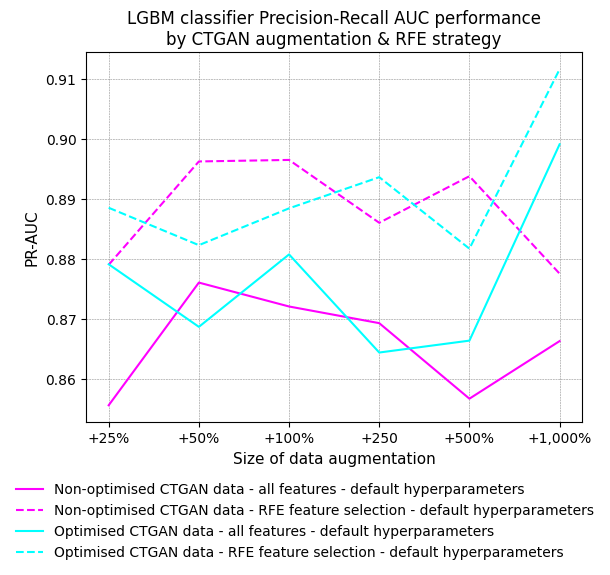

In [ ]:
plt.plot(rfe_metrics_summary_all_feats1.pr_auc[1:], label='Non-optimised CTGAN data - all features - default hyperparameters',color='magenta')
plt.plot(rfe_metrics_summary_best_model1.pr_auc[1:], label='Non-optimised CTGAN data - RFE feature selection - default hyperparameters',color='magenta',linestyle='--')

plt.plot(rfe_metrics_summary_all_feats_o1.pr_auc[1:], label='Optimised CTGAN data - all features - default hyperparameters',color='cyan')
plt.plot(rfe_metrics_summary_best_model_o1.pr_auc[1:], label='Optimised CTGAN data - RFE feature selection - default hyperparameters',color='cyan',linestyle='--')

new_xticks = [0, 1, 2, 3, 4, 5]
new_xtick_labels = ['+25%', '+50%', '+100%', '+250','+500%','+1,000%']
plt.xticks(new_xticks, new_xtick_labels)
plt.xlabel('Size of data augmentation',fontsize=11)
plt.ylabel('PR-AUC',fontsize=11)
plt.title('LGBM classifier Precision-Recall AUC performance\nby CTGAN augmentation & RFE strategy')
plt.grid(True, linestyle='--', color='gray', linewidth=0.36)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, -0.13), frameon=False)
plt.show()

#### **5.2. RFE best features with random search hypers**

Get metric summaries

In [ ]:
# Non-optimised
rfe_metrics_summary_best_model_rs=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_rs.pkl')

# Optimised
rfe_metrics_summary_best_model_o_rs=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/rfe_metrics_summary_best_model_o_rs.pkl')
new_index= {'_bal_o': '_bal', '_25_o': '_25', '_50_o': '_50', '_100_o': '_100', '_250_o': '_250', '_500_o': '_500', '_1000_o': '_1000'}
rfe_metrics_summary_best_model_o_rs=rfe_metrics_summary_best_model_o_rs.rename(index=new_index)

Review metric summaries

Non-optimised CTGAN data - RFE best features - RS hypers

In [ ]:
rfe_metrics_summary_best_model_rs

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc
_bal,130,31,16,81,0.467648,0.624031,0.616114,0.890411,0.659574,0.728291,0.874082,0.660785
_25,155,22,25,56,0.459705,0.686047,0.734597,0.861111,0.468085,0.792839,0.849353,0.598064
_50,124,27,20,87,0.477884,0.585271,0.587678,0.861111,0.574468,0.698592,0.847565,0.581980
_100,170,21,26,41,0.485676,0.740310,0.805687,0.867347,0.446809,0.835381,0.851005,0.606938
_250,146,27,20,65,0.480271,0.670543,0.691943,0.879518,0.574468,0.774536,0.863173,0.636987
_500,130,31,16,81,0.504873,0.624031,0.616114,0.890411,0.659574,0.728291,0.880887,0.639508
_1000,165,23,24,46,0.512602,0.728682,0.781991,0.873016,0.489362,0.825000,0.882951,0.638600


Optimised CTGAN data - RFE best features - RS hypers

In [ ]:
rfe_metrics_summary_best_model_o_rs

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc
_bal,130,31,16,81,0.467648,0.624031,0.616114,0.890411,0.659574,0.728291,0.874082,0.660785
_25,158,23,24,53,0.459366,0.701550,0.748815,0.868132,0.489362,0.804071,0.881833,0.653171
_50,102,38,9,109,0.728103,0.542636,0.483412,0.918919,0.808511,0.633540,0.883573,0.593627
_100,197,5,42,14,0.484444,0.782946,0.933649,0.824268,0.106383,0.875556,0.823797,0.519764
_250,146,28,19,65,0.461451,0.674419,0.691943,0.884848,0.595745,0.776596,0.900375,0.684885
_500,170,20,27,41,0.473543,0.736434,0.805687,0.862944,0.425532,0.833333,0.868262,0.612030
_1000,111,36,11,100,0.662760,0.569767,0.526066,0.909836,0.765957,0.666667,0.901734,0.656953


Plot PR-AUC by strategy combination

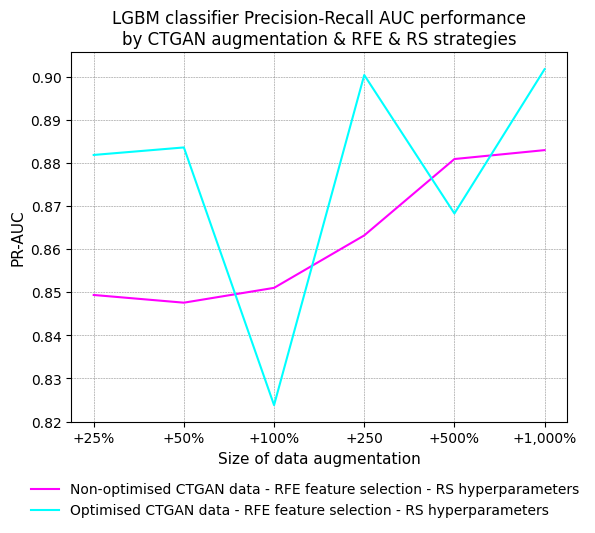

In [ ]:
plt.plot(rfe_metrics_summary_best_model_rs.pr_auc[1:], label='Non-optimised CTGAN data - RFE feature selection - RS hyperparameters',color='magenta')
plt.plot(rfe_metrics_summary_best_model_o_rs.pr_auc[1:], label='Optimised CTGAN data - RFE feature selection - RS hyperparameters',color='cyan')
new_xticks = [0, 1, 2, 3, 4, 5]
new_xtick_labels = ['+25%', '+50%', '+100%', '+250','+500%','+1,000%']
plt.xticks(new_xticks, new_xtick_labels)
plt.xlabel('Size of data augmentation',fontsize=11)
plt.ylabel('PR-AUC',fontsize=11)
plt.title('LGBM classifier Precision-Recall AUC performance\nby CTGAN augmentation & RFE & RS strategies')
plt.grid(True, linestyle='--', color='gray', linewidth=0.36)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, -0.13), frameon=False)
plt.show()

#### **5.3. GA features with default hypers & GA features with GA hypers**

Get metric summaries

In [ ]:
# Non-optimized CTGAN

# GA feats - default hypers
metrics_f_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all.pkl')
# GA feats & hyps
metrics_fh_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all.pkl')

# Optimized CTGAN

# GA feats - default hypers
metrics_f_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all_o.pkl')
new_index= {'_bal_o': '_bal', '_25_o': '_25', '_50_o': '_50', '_100_o': '_100', '_250_o': '_250', '_500_o': '_500', '_1000_o': '_1000'}
metrics_f_all_o=metrics_f_all_o.rename(index=new_index)

# GA feats & hyps
metrics_fh_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all_o.pkl')
metrics_fh_all_o=metrics_fh_all_o.rename(index=new_index)

Review metric summaries

Non-optimised CTGAN data

In [ ]:
# GA feats & default hypers
metrics_f_all

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,156,35,12,55,0.469490,0.740310,0.739336,0.928571,0.744681,0.823219,0.940606,0.777755,0.859396
_25,146,33,14,65,0.496455,0.693798,0.691943,0.912500,0.702128,0.787062,0.937505,0.762832,0.925880
_50,125,40,7,86,0.468632,0.639535,0.592417,0.946970,0.851064,0.728863,0.941474,0.775033,0.943918
_100,148,35,12,63,0.504586,0.709302,0.701422,0.925000,0.744681,0.797844,0.939137,0.765655,0.972379
_250,146,34,13,65,0.526194,0.697674,0.691943,0.918239,0.723404,0.789189,0.933920,0.741051,0.982332
_500,129,40,7,82,0.489489,0.655039,0.611374,0.948529,0.851064,0.743516,0.939954,0.758193,0.995775
_1000,125,42,5,86,0.504182,0.647287,0.592417,0.961538,0.893617,0.733138,0.939957,0.756983,0.999059


In [ ]:
# GA feats & GA hypers
metrics_fh_all

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,135,41,6,76,0.434393,0.682171,0.639810,0.957447,0.872340,0.767045,0.945899,0.793183,0.872660
_25,164,31,16,47,0.451846,0.755814,0.777251,0.911111,0.659574,0.838875,0.941509,0.769890,0.931495
_50,128,43,4,83,0.432465,0.662791,0.606635,0.969697,0.914894,0.746356,0.946525,0.782192,0.945796
_100,151,36,11,60,0.526202,0.724806,0.715640,0.932099,0.765957,0.809651,0.942979,0.780982,0.973261
_250,122,38,9,89,0.478335,0.620155,0.578199,0.931298,0.808511,0.713450,0.933294,0.739437,0.982942
_500,154,34,13,57,0.416574,0.728682,0.729858,0.922156,0.723404,0.814815,0.949069,0.790662,0.995865
_1000,139,37,10,72,0.399424,0.682171,0.658768,0.932886,0.787234,0.772222,0.949608,0.791469,0.999131


Optimised CTGAN data

In [ ]:
# GA feats & default hypers
metrics_f_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,156,35,12,55,0.469490,0.740310,0.739336,0.928571,0.744681,0.823219,0.940606,0.777755,0.859396
_25,143,37,10,68,0.471154,0.697674,0.677725,0.934641,0.787234,0.785714,0.943780,0.782192,0.890566
_50,148,35,12,63,0.495465,0.709302,0.701422,0.925000,0.744681,0.797844,0.942062,0.764647,0.939961
_100,159,33,14,52,0.480700,0.744186,0.753555,0.919075,0.702128,0.828125,0.945432,0.784814,0.965836
_250,144,34,13,67,0.552227,0.689922,0.682464,0.917197,0.723404,0.782609,0.935251,0.754966,0.981528
_500,153,32,15,58,0.511203,0.717054,0.725118,0.910714,0.680851,0.807388,0.935096,0.757185,0.993948
_1000,149,32,15,62,0.540613,0.701550,0.706161,0.908537,0.680851,0.794667,0.937627,0.755269,0.996230


In [ ]:
# GA feats & GA hypers
metrics_fh_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,135,41,6,76,0.434393,0.682171,0.639810,0.957447,0.872340,0.767045,0.945899,0.793183,0.872660
_25,169,33,14,42,0.410488,0.782946,0.800948,0.923497,0.702128,0.857868,0.945507,0.792074,0.887306
_50,143,39,8,68,0.508325,0.705426,0.677725,0.947020,0.829787,0.790055,0.948054,0.780478,0.935298
_100,120,43,4,91,0.420769,0.631783,0.568720,0.967742,0.914894,0.716418,0.947756,0.786427,0.965157
_250,155,34,13,56,0.495472,0.732558,0.734597,0.922619,0.723404,0.817942,0.942185,0.778159,0.979181
_500,169,29,18,42,0.406961,0.767442,0.800948,0.903743,0.617021,0.849246,0.939075,0.774024,0.994299
_1000,135,39,8,76,0.502462,0.674419,0.639810,0.944056,0.829787,0.762712,0.940896,0.771100,0.996448


Plot PR-AUC by strategy

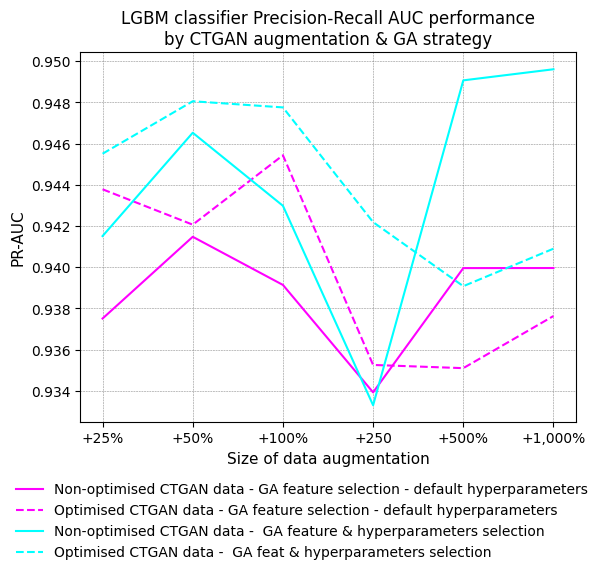

In [ ]:
plt.plot(metrics_f_all.pr_auc[1:], label='Non-optimised CTGAN data - GA feature selection - default hyperparameters',color='magenta')
plt.plot(metrics_f_all_o.pr_auc[1:], label='Optimised CTGAN data - GA feature selection - default hyperparameters',color='magenta',linestyle='--')
plt.plot(metrics_fh_all.pr_auc[1:], label='Non-optimised CTGAN data -  GA feature & hyperparameters selection',color='cyan')
plt.plot(metrics_fh_all_o.pr_auc[1:], label='Optimised CTGAN data -  GA feat & hyperparameters selection',color='cyan',linestyle='--')
new_xticks = [0, 1, 2, 3, 4, 5]
new_xtick_labels = ['+25%', '+50%', '+100%', '+250','+500%','+1,000%']
plt.xticks(new_xticks, new_xtick_labels)
plt.xlabel('Size of data augmentation',fontsize=11)
plt.ylabel('PR-AUC',fontsize=11)
plt.title('LGBM classifier Precision-Recall AUC performance\nby CTGAN augmentation & GA strategy')
plt.grid(True, linestyle='--', color='gray', linewidth=0.36)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, -0.13), frameon=False)
plt.show()

#### **5.4. Performance summary for all models by augmentation scenario & modelling method**

- Brings together all the plots from above and summaries into two plots - one for PR-AUC & one for ROC-AUC

- SHOWS THAT WHILE THERE ARE CLEAR PERFORMANCE IMPROVEMENTS AS MODELLING METHODOLOGY (FEATURE/HYPERPARAMETER SELECTION) IMPROVES THERE IS NO CLEAR DISTINCTION IN PERFORMANCE WHEN USING SYNTHETIC DATA FROM OPTIMISED CTGAN OVER SYNTHETIC DATA FROM NON-OPTIMISED CTGAN. MAYBE THE HYPERPARAMETER SELECTION NEEDS TO BE REVISITED FOR THE OPTIMISED SCENARIO

In [ ]:
# Data required:

# # CTGAN non-optimised

# # All features & default hyperparameters
# rfe_metrics_summary_all_feats1
# # RFE features & default hyperparameters
# rfe_metrics_summary_best_model1
# # RFE features & RS hyperparameters
# rfe_metrics_summary_best_model_rs
# # GA feats & default hypers
# metrics_f_all
# # GA feats & GA hyps
# metrics_fh_all

# # CTGAN optimised

# # All features & default hyperparameters
# rfe_metrics_summary_all_feats_o1
# # RFE features & default hyperparameters
# rfe_metrics_summary_best_model_o1
# # RFE features & RS hyperparameters
# rfe_metrics_summary_best_model_o_rs
# # GA feats & default hypers
# metrics_f_all_o
# # GA feats & GA hyps
# metrics_fh_all_o

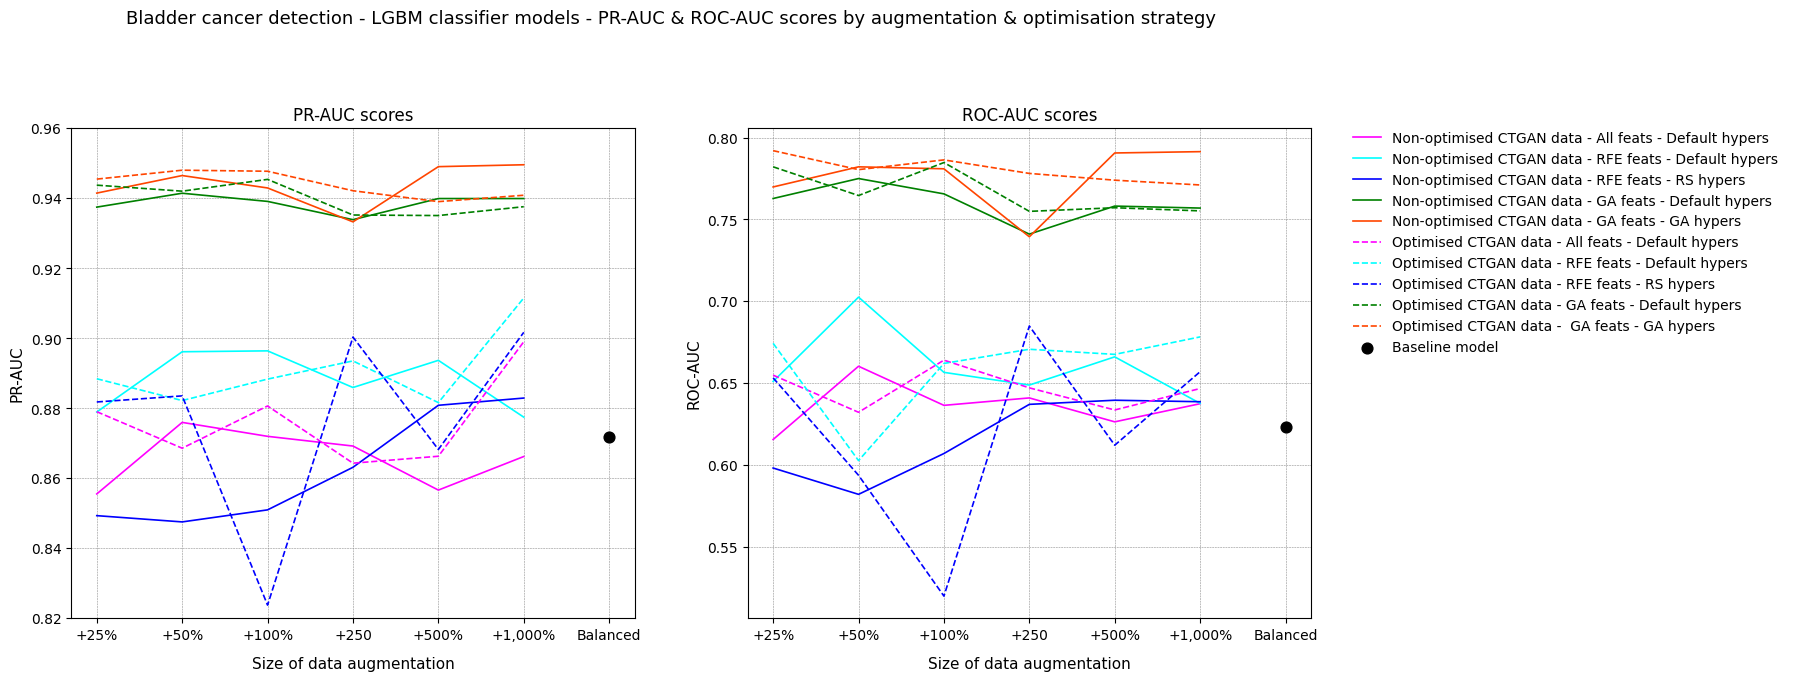

In [ ]:
fig, axes=plt.subplots(1,2,figsize=(16,7),gridspec_kw={'hspace': 0.3}) # width by height

########## PR-AUC ##########

# CTGAN non-optimised
axes[0].plot(rfe_metrics_summary_all_feats1.pr_auc[1:], label='Non-optimised CTGAN data - All feats - Default hypers',color='magenta',lw=1.2)
axes[0].plot(rfe_metrics_summary_best_model1.pr_auc[1:], label='Non-optimised CTGAN data - RFE feats - Default hypers',color='cyan',lw=1.2)
axes[0].plot(rfe_metrics_summary_best_model_rs.pr_auc[1:], label='Non-optimised CTGAN data - RFE feats - RS hypers',color='blue',lw=1.2)
axes[0].plot(metrics_f_all.pr_auc[1:], label='Non-optimised CTGAN data - GA feats - Default hypers',color='green',lw=1.2)
axes[0].plot(metrics_fh_all.pr_auc[1:], label='Non-optimised CTGAN data - GA feats - GA hypers',color='orangered',lw=1.2)

# CTGAN optimised
axes[0].plot(rfe_metrics_summary_all_feats_o1.pr_auc[1:], label='Optimised CTGAN data - All feats - Default hypers',color='magenta',linestyle='--',lw=1.2)
axes[0].plot(rfe_metrics_summary_best_model_o1.pr_auc[1:], label='Optimised CTGAN data - RFE feats - Default hypers',color='cyan',linestyle='--',lw=1.2)
axes[0].plot(rfe_metrics_summary_best_model_o_rs.pr_auc[1:], label='Optimised CTGAN data - RFE feats - RS hypers',color='blue',linestyle='--',lw=1.2)
axes[0].plot(metrics_f_all_o.pr_auc[1:], label='Optimised CTGAN data - GA feats - Default hypers',color='green',linestyle='--',lw=1.2)
axes[0].plot(metrics_fh_all_o.pr_auc[1:], label='Optimised CTGAN data -  GA feats - GA hypers',color='orangered',linestyle='--',lw=1.2)

# Add baseline model
axes[0].scatter(6,rfe_metrics_summary_all_feats1.iloc[0,-3], color='black', label='Baseline model', zorder=5, s=60)

# Tidy up plot
new_xticks = [0,1,2,3,4,5,6]
new_xtick_labels = ['+25%','+50%','+100%','+250','+500%','+1,000%','Balanced']
axes[0].set_xticks(new_xticks, new_xtick_labels)
axes[0].set_xlabel('Size of data augmentation',fontsize=11,labelpad=10)
axes[0].set_ylim(0.82, 0.96)
axes[0].set_ylabel('PR-AUC',fontsize=11)
axes[0].set_title('PR-AUC scores')
axes[0].grid(True, linestyle='--', color='gray', linewidth=0.36)
axes[0].legend(loc='upper right', bbox_to_anchor=(3.05, 1.02), frameon=False)

########## ROC-AUC ##########

# CTGAN non-optimised
axes[1].plot(rfe_metrics_summary_all_feats1.roc_auc[1:], label='Non-optimised CTGAN data - All features - Default hyperparameters',color='magenta',lw=1.2)
axes[1].plot(rfe_metrics_summary_best_model1.roc_auc[1:], label='Non-optimised CTGAN data - RFE features - Default hyperparameters',color='cyan',lw=1.2)
axes[1].plot(rfe_metrics_summary_best_model_rs.roc_auc[1:], label='Non-optimised CTGAN data - RFE features - RS hyperparameters',color='blue',lw=1.2)
axes[1].plot(metrics_f_all.roc_auc[1:], label='Non-optimised CTGAN data - GA features - Default hyperparameters',color='green',lw=1.2)
axes[1].plot(metrics_fh_all.roc_auc[1:], label='Non-optimised CTGAN data - GA feature - GA hyperparameters',color='orangered',lw=1.2)

# CTGAN optimised
axes[1].plot(rfe_metrics_summary_all_feats_o1.roc_auc[1:], label='Optimised CTGAN data - All features - Default hyperparameters',color='magenta',linestyle='--',lw=1.2)
axes[1].plot(rfe_metrics_summary_best_model_o1.roc_auc[1:], label='Optimised CTGAN data - RFE features - Default hyperparameters',color='cyan',linestyle='--',lw=1.2)
axes[1].plot(rfe_metrics_summary_best_model_o_rs.roc_auc[1:], label='Optimised CTGAN data - RFE features - RS hyperparameters',color='blue',linestyle='--',lw=1.2)
axes[1].plot(metrics_f_all_o.roc_auc[1:], label='Optimised CTGAN data - GA features - Default hyperparameters',color='green',linestyle='--',lw=1.2)
axes[1].plot(metrics_fh_all_o.roc_auc[1:], label='Optimised CTGAN data -  GA features - GA hyperparameters',color='orangered',linestyle='--',lw=1.2)

# Add baseline model
axes[1].scatter(6,rfe_metrics_summary_all_feats1.iloc[0,-2], color='black', label='Baseline model', zorder=5, s=60)

# Tidy up plot
new_xticks = [0, 1, 2, 3, 4, 5, 6]
new_xtick_labels = ['+25%', '+50%', '+100%', '+250', '+500%', '+1,000%', 'Balanced',]
axes[1].set_xticks(new_xticks, new_xtick_labels)
axes[1].set_xlabel('Size of data augmentation',fontsize=11,labelpad=10)
axes[1].set_ylabel('ROC-AUC',fontsize=11)
axes[1].set_title('ROC-AUC scores')
axes[1].grid(True, linestyle='--', color='gray', linewidth=0.36)

fig.suptitle('Bladder cancer detection - LGBM classifier models - PR-AUC & ROC-AUC scores by augmentation & optimisation strategy', fontsize=13)
fig.subplots_adjust(top=0.81)

plt.tight_layout()
plt.show()

### **6. Deep dive into best models**

- As there is no clear advantage over using optimised or non-optimised CTGAN for synthetic data generation will analyse the best mperformaning model - in terms of PR-AUC - for both

- Best model when using optimised CTGAN for synthetic data generation:

 - Augmentation strategy = + 50%
 - Feats/hypers optimisation strategy = GA features & GA hyperparameters
 - PR-AUC = 0.948054

- Best model when using non-optimised CTGAN for synthetic data generation:

 - Augmentation strategy = + 1,000%
 - Feats/hypers optimisation strategy = GA features & GA hyperparameters
 - PR-AUC = 0.949608

- Baseline model comprises:

 - Non-optimised CTGAN data samples for balancing classes
 - All features & default hypers
 - PR-AUC = 0.871711

#### **6.1. PR & ROC curves for all methodologies**

**Best model using optimised data - +50%**

In [ ]:
########## Get data from saved pickle objects ##########

##### Get training & test data from saved data #####

# 50 - augmented training & hold-out test data
# Note that 'df_test_imp_t_ctgan' comprises synthetic data from non-optimized CTGAN
x_train_50_o, y_train_50_o, x_test_50_o, y_test_50_o, sizing_50_o = data_prep('_50', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

# bal - augmented training & hold-out test data - for performance comparison
x_train_bal, y_train_bal, x_test_bal, y_test_bal, sizing_bal = data_prep('_bal', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get PR & ROC curve data from saved data #####

# 50 - model - optimised - all feats - default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_all_feats_model', 'rb') as file:
    _50_o_all_feats_model=pickle.load(file)
_50_all_feats_metrics_o,_50_all_feats_feat_imp_o,_50_all_feats_pr_curve_dic_o,_50_all_feats_roc_curve_dic_o=model_eval('_50_o',y_test_50_o,_50_o_all_feats_model['y_pred'],_50_o_all_feats_model['y_class'],_50_o_all_feats_model['feat_names'],_50_o_all_feats_model['feat_imp'],valid_score=None,assign_method='ss')

# 50 - model - optimised - RFE feats - default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_50_o_best_model', 'rb') as file:
    _50_o_best_model=pickle.load(file)
_50_best_model_metrics_o,_50_best_model_feat_imp_o,_50_best_model_pr_curve_dic_o,_50_best_model_roc_curve_dic_o=model_eval('_50_o',y_test_50_o,_50_o_best_model['y_pred'],_50_o_best_model['y_class'],_50_o_best_model['feat_names'],_50_o_best_model['feat_imp'],valid_score=None,assign_method='ss')

# 50 - model - optimised - RFE feats - RS hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'rb') as file:
  y_pred_50_o_rs=pickle.load(file)
precision_o,recall_o,thresholds1_o=precision_recall_curve(y_test_50_o,y_pred_50_o_rs)
fpr_o,tpr_o,thresholds2_o=roc_curve(y_test_50_o,y_pred_50_o_rs)

# 50 - model - optimised - GA feats & default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50_o', 'rb') as file:
  pr_curve_dic_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50_o', 'rb') as file:
  roc_curve_dic_f_50_o=pickle.load(file)

# 50 - model - optimised - GA feats & GA hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o', 'rb') as file:
  pr_curve_dic_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o', 'rb') as file:
  roc_curve_dic_fh_50_o=pickle.load(file)

# bal - model - non-optimised - all feats - default hypers (baseline model)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_all_feats_model', 'rb') as file:
    _bal_all_feats_model=pickle.load(file)
_bal_all_feats_metrics,_bal_all_feats_feat_imp,_bal_all_feats_pr_curve_dic,_bal_all_feats_roc_curve_dic=model_eval('_bal',y_test_bal, _bal_all_feats_model['y_pred'],_bal_all_feats_model['y_class'],_bal_all_feats_model['feat_names'],_bal_all_feats_model['feat_imp'],valid_score=None,assign_method='ss')

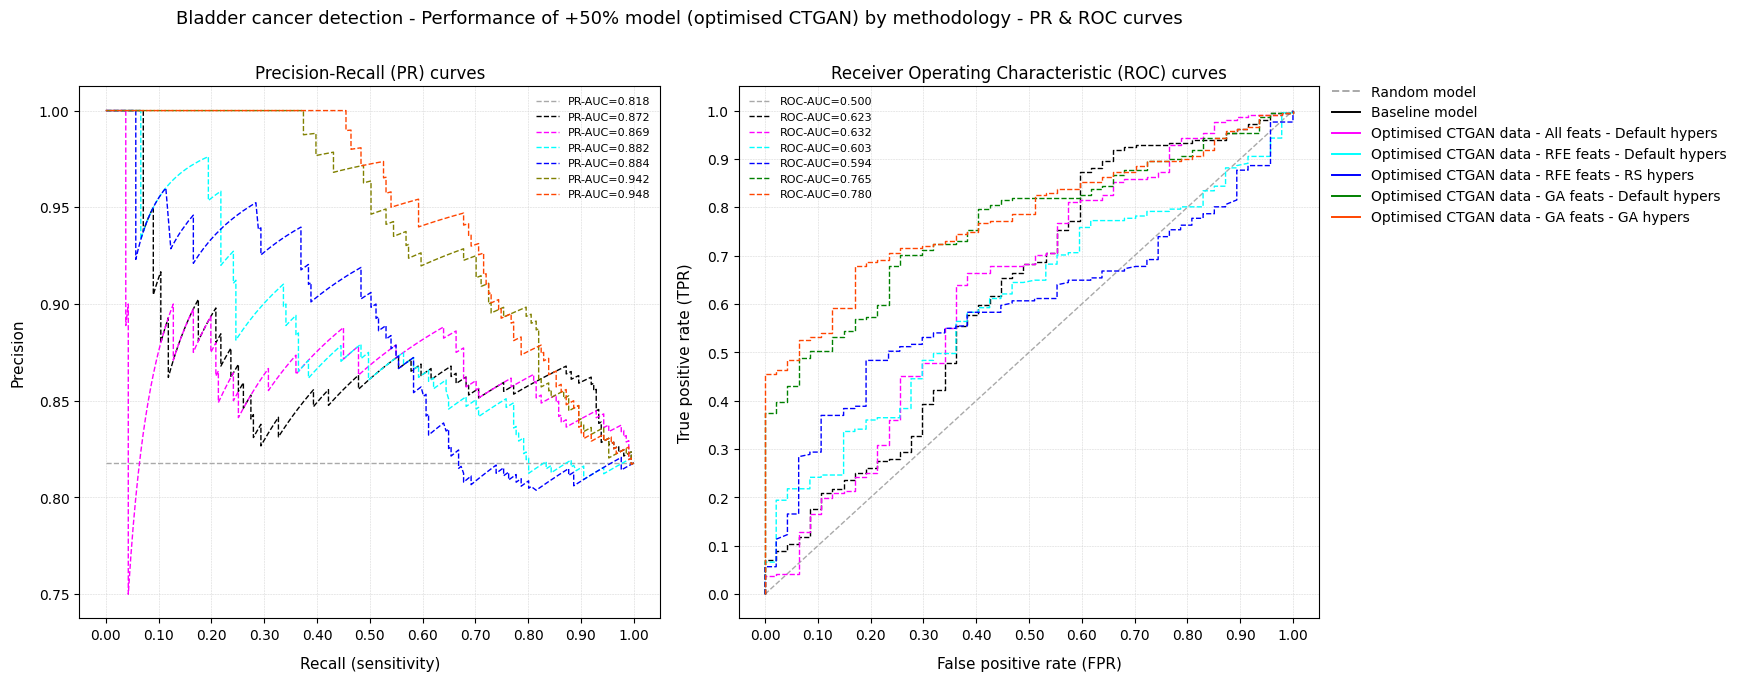

In [ ]:
########## Plot PR curves ##########

fig, axes=plt.subplots(1,2,figsize=(16,7)) # width by height

# These are in order of model complexity:

# Random model (same for all augmentation scenarios)
axes[0].plot([0, 1],
             [_50_all_feats_pr_curve_dic_o['_50_o']['random_model'],
              _50_all_feats_pr_curve_dic_o['_50_o']['random_model']],
             label=f"PR-AUC={_50_all_feats_pr_curve_dic_o['_50_o']['random_model']:.3f}",
             linestyle='--',
             color='darkgray',
             lw=1)

# Bal (baseline model) - model - optimised - all feats - default hypers
axes[0].plot(_bal_all_feats_pr_curve_dic['_bal']['recall'],
             _bal_all_feats_pr_curve_dic['_bal']['precision'],
             label=f'PR-AUC={_bal_all_feats_pr_curve_dic["_bal"]["pr_auc"]:.3f}',
             linestyle='--',
             color='black',
             lw=1)

# 50 - model - optimised - all feats - default hypers
axes[0].plot(_50_all_feats_pr_curve_dic_o["_50_o"]["recall"],
             _50_all_feats_pr_curve_dic_o["_50_o"]["precision"],
             label=f'PR-AUC={_50_all_feats_pr_curve_dic_o["_50_o"]["pr_auc"]:.3f}',
             linestyle='--',
             color="magenta",
             lw=1)

# 50  - model - optimised - RFE feats - default hypers
axes[0].plot(_50_best_model_pr_curve_dic_o["_50_o"]["recall"],
             _50_best_model_pr_curve_dic_o["_50_o"]["precision"],
             label=f"PR-AUC={_50_best_model_pr_curve_dic_o['_50_o']['pr_auc']:.3f}",
             linestyle='--',
             color="cyan",
             lw=1)

# 50  - model - optimised - RFE feats - RS hypers
axes[0].plot(recall_o,
             precision_o,
             label=f"PR-AUC={0.883573:.3f}",
             linestyle='--',
             color="blue",
             lw=1)

# 50  - model - optimised - GA feats & default hypers
axes[0].plot(pr_curve_dic_f_50_o['_50_o']['recall'],
             pr_curve_dic_f_50_o['_50_o']['precision'],
             label=f"PR-AUC={pr_curve_dic_f_50_o['_50_o']['pr_auc']:.3f}",
             linestyle='--',
             color="olive",
             lw=1)

# 50  - model - optimised - GA feats & GA hypers
axes[0].plot(pr_curve_dic_fh_50_o['_50_o']['recall'],
             pr_curve_dic_fh_50_o['_50_o']['precision'],
             label=f"PR-AUC={pr_curve_dic_fh_50_o['_50_o']['pr_auc']:.3f}",
             linestyle='--',
             color="orangered",
             lw=1)

########## ROC curve ##########

# Random model (same for all augmentation scenarios)
line1, =axes[1].plot([0, 1],
                     [0, 1],
                     label=f"ROC-AUC={0.5:.3f}",
                     linestyle='--',
                     color='darkgray',
                     lw=1)

# Bal (baseline model) - model - non-optimised - all feats - default hypers
line0, =axes[1].plot(_bal_all_feats_roc_curve_dic['_bal']['fpr'],
                     _bal_all_feats_roc_curve_dic['_bal']['tpr'],
                     label=f'ROC-AUC={_bal_all_feats_roc_curve_dic["_bal"]["roc_auc"]:.3f}',
                     linestyle='--',
                     color='black',
                     lw=1)

# 50  - model - optimised - all feats - default hypers
line2, =axes[1].plot(_50_all_feats_roc_curve_dic_o["_50_o"]["fpr"],
                     _50_all_feats_roc_curve_dic_o["_50_o"]["tpr"],
                     label=f'ROC-AUC={_50_all_feats_roc_curve_dic_o["_50_o"]["roc_auc"]:.3f}',
                     linestyle='--',
                     color="magenta",
                     lw=1)

# 50  - model - optimised - RFE feats - default hypers
line3, =axes[1].plot(_50_best_model_roc_curve_dic_o["_50_o"]["fpr"],
                     _50_best_model_roc_curve_dic_o["_50_o"]["tpr"],
                     label=f"ROC-AUC={_50_best_model_roc_curve_dic_o['_50_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="cyan",
                     lw=1)

# 50  - model - optimised - RFE feats - RS hypers
line4, =axes[1].plot(fpr_o,
                     tpr_o,
                     label=f"ROC-AUC={0.593627:.3f}",
                     linestyle='--',
                     color="blue",
                     lw=1)

# 50  - model - optimised - GA feats & default hypers
line5, =axes[1].plot(roc_curve_dic_f_50_o['_50_o']['fpr'],
                     roc_curve_dic_f_50_o['_50_o']['tpr'],
                     label=f"ROC-AUC={roc_curve_dic_f_50_o['_50_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="green",
                     lw=1)

# 50  - model - optimised - GA feats & GA hypers
line6, =axes[1].plot(roc_curve_dic_fh_50_o['_50_o']['fpr'],
                     roc_curve_dic_fh_50_o['_50_o']['tpr'],
                     label=f"ROC-AUC={roc_curve_dic_fh_50_o['_50_o']['roc_auc']:.3f}",
                     linestyle='--',
                     color="orangered",
                     lw=1)

# Tidy up plots
fig.suptitle('Bladder cancer detection - Performance of +50% model (optimised CTGAN) by methodology - PR & ROC curves', fontsize=13)
fig.subplots_adjust(top=0.87, wspace=0.135)

custom_ticks = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]

axes[0].set_xticks(custom_ticks)
axes[0].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[0].set_xlabel('Recall (sensitivity)',fontsize=11,labelpad=10)
axes[0].set_ylabel('Precision',fontsize=11,labelpad=10)
axes[0].set_title('Precision-Recall (PR) curves')
axes[0].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[0].legend(loc='upper right', frameon=False, fontsize=8)

axes[1].set_xticks(custom_ticks)
axes[1].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[1].set_yticks(custom_ticks)
axes[1].set_xlabel('False positive rate (FPR)',fontsize=11,labelpad=10)
axes[1].set_ylabel('True positive rate (TPR)',fontsize=11,labelpad=10)
axes[1].set_title('Receiver Operating Characteristic (ROC) curves')
axes[1].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[1].legend(loc='upper left', frameon=False, fontsize=8)

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Random model'),
                       Line2D([0], [0], color=line0.get_color(), lw=1.4, label='Baseline model'),
                       Line2D([0], [0], color=line2.get_color(), lw=1.4, label='Optimised CTGAN data - All feats - Default hypers'),
                       Line2D([0], [0], color=line3.get_color(), lw=1.4, label='Optimised CTGAN data - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line4.get_color(), lw=1.4, label='Optimised CTGAN data - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line5.get_color(), lw=1.4, label='Optimised CTGAN data - GA feats - Default hypers'),
                       Line2D([0], [0], color=line6.get_color(), lw=1.4, label='Optimised CTGAN data - GA feats - GA hypers')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.90, 0.89), loc='upper left', frameon=False)

plt.show()

**Best model using non-optimised data - +1,000%**

In [ ]:
########## Get data from saved pickle objects ##########

##### Get training & test data from saved data #####

# 1000 - augmented training & hold-out test data
# Note that 'df_test_imp_t_ctgan' comprises synthetic data from non-optimized CTGAN
x_train_1000, y_train_1000, x_test_1000, y_test_1000, sizing_1000 = data_prep('_1000', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

# bal - augmented training & hold-out test data - for performance comparison
x_train_bal, y_train_bal, x_test_bal, y_test_bal, sizing_bal = data_prep('_bal', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get PR & ROC curve data from saved data #####

# 1000 - model - non-optimised - all feats - default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_all_feats_model', 'rb') as file:
    _1000_all_feats_model=pickle.load(file)
_1000_all_feats_metrics,_1000_all_feats_feat_imp,_1000_all_feats_pr_curve_dic,_1000_all_feats_roc_curve_dic=model_eval('_1000',y_test_1000,_1000_all_feats_model['y_pred'],_1000_all_feats_model['y_class'],_1000_all_feats_model['feat_names'],_1000_all_feats_model['feat_imp'],valid_score=None,assign_method='ss')

# 1000 - model - non-optimised - RFE feats - default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_1000_best_model', 'rb') as file:
    _1000_best_model=pickle.load(file)
_1000_best_model_metrics,_1000_best_model_feat_imp,_1000_best_model_pr_curve_dic,_1000_best_model_roc_curve_dic=model_eval('_1000',y_test_1000,_1000_best_model['y_pred'],_1000_best_model['y_class'],_1000_best_model['feat_names'],_1000_best_model['feat_imp'],valid_score=None,assign_method='ss')

# 1000 - model - non-optimised - RFE feats - RS hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_rs', 'rb') as file:
  y_pred_1000_rs=pickle.load(file)
precision,recall,thresholds1=precision_recall_curve(y_test_1000,y_pred_1000_rs)
fpr,tpr,thresholds2=roc_curve(y_test_1000,y_pred_1000_rs)

# 1000 - model - non-optimised - GA feats & default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000', 'rb') as file:
  pr_curve_dic_f_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000', 'rb') as file:
  roc_curve_dic_f_1000=pickle.load(file)

# 1000 - model - non-optimised - GA feats & GA hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000', 'rb') as file:
  pr_curve_dic_fh_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000', 'rb') as file:
  roc_curve_dic_fh_1000=pickle.load(file)

# bal - model - non-optimised - all feats - default hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_all_feats_model', 'rb') as file:
    _bal_all_feats_model=pickle.load(file)
_bal_all_feats_metrics,_bal_all_feats_feat_imp,_bal_all_feats_pr_curve_dic,_bal_all_feats_roc_curve_dic=model_eval('_bal',y_test_bal, _bal_all_feats_model['y_pred'],_bal_all_feats_model['y_class'],_bal_all_feats_model['feat_names'],_bal_all_feats_model['feat_imp'],valid_score=None,assign_method='ss')


In [ ]:
########## Extract required data arrays ##########

##### Bal - model - non-optimised - RFE feats - default hypers #####

# Extract from _bal_best_model_pr_curve_dic:
#_bal_all_feats_pr_curve_dic['_bal']['precision']
#_bal_all_feats_pr_curve_dic['_bal']['recall']
#_bal_all_feats_pr_curve_dic['_bal']['pr_auc']
#_bal_all_feats_pr_curve_dic['_bal']['random_model']

# Extract from _bal_best_model_roc_curve_dic:
#_bal_all_feats_roc_curve_dic['_bal']['fpr']
#_bal_all_feats_roc_curve_dic['_bal']['tpr']
#_bal_all_feats_roc_curve_dic['_bal']['roc_auc']

##### 1000 - model - non-optimised - all feats - default hypers #####

# Extract from _1000_all_feats_pr_curve_dic:
#_1000_all_feats_pr_curve_dic['_1000']['precision']
#_1000_all_feats_pr_curve_dic['_1000']['recall']
#_1000_all_feats_pr_curve_dic['_1000']['pr_auc']
#_1000_all_feats_pr_curve_dic['_1000']['random_model']

# Extract from _1000_all_feats_roc_curve_dic:
#_1000_all_feats_roc_curve_dic['_1000']['fpr']
#_1000_all_feats_roc_curve_dic['_1000']['tpr']
#_1000_all_feats_roc_curve_dic['_1000']['roc_auc']

##### 1000 - model - non-optimised - RFE feats - default hypers #####

# Extract from _1000_best_model_pr_curve_dic:
#_1000_best_model_pr_curve_dic['_1000']['precision']
#_1000_best_model_pr_curve_dic['_1000']['recall']
#_1000_best_model_pr_curve_dic['_1000']['pr_auc']
#_1000_best_model_pr_curve_dic['_1000']['random_model']

# Extract f_model_om _1000_best_model_roc_curve_dic:
#_1000_best_model_roc_curve_dic['_1000']['fpr']
#_1000_best_model_roc_curve_dic['_1000']['tpr']
#_1000_best_model_roc_curve_dic['_1000']['roc_auc']

##### 1000 - model - non-optimised-RFE feats-RS hypers #####

#precision,recall,thresholds1
#fpr,tpr,thresholds2

##### 1000 - model - non-optimised - GA feats & default hypers #####

# Extract from pr_curve_dic_f_1000:
# pr_curve_dic_f_1000['_1000']['precision']
# pr_curve_dic_f_1000['_1000']['recall']
# pr_curve_dic_f_1000['_1000']['pr_auc']
# pr_curve_dic_f_1000['_1000']['random_model']

# Extract from roc_curve_dic_f_1000:
# roc_curve_dic_f_1000['_1000']['fpr']
# roc_curve_dic_f_1000['_1000']['tpr']
# roc_curve_dic_f_1000['_1000']['roc_auc']

##### 1000 - model - non-optimised - GA feats & GA hypers #####

# Extract from pr_curve_dic_fh_1000:
# pr_curve_dic_fh_1000['_1000']['precision']
# pr_curve_dic_fh_1000['_1000']['recall']
# pr_curve_dic_fh_1000['_1000']['pr_auc']
# pr_curve_dic_fh_1000['_1000']['random_model']

# Extract from roc_curve_dic_fh_1000:
# roc_curve_dic_fh_1000['_1000']['fpr']
# roc_curve_dic_fh_1000['_1000']['tpr']
# roc_curve_dic_fh_1000['_1000']['roc_auc']

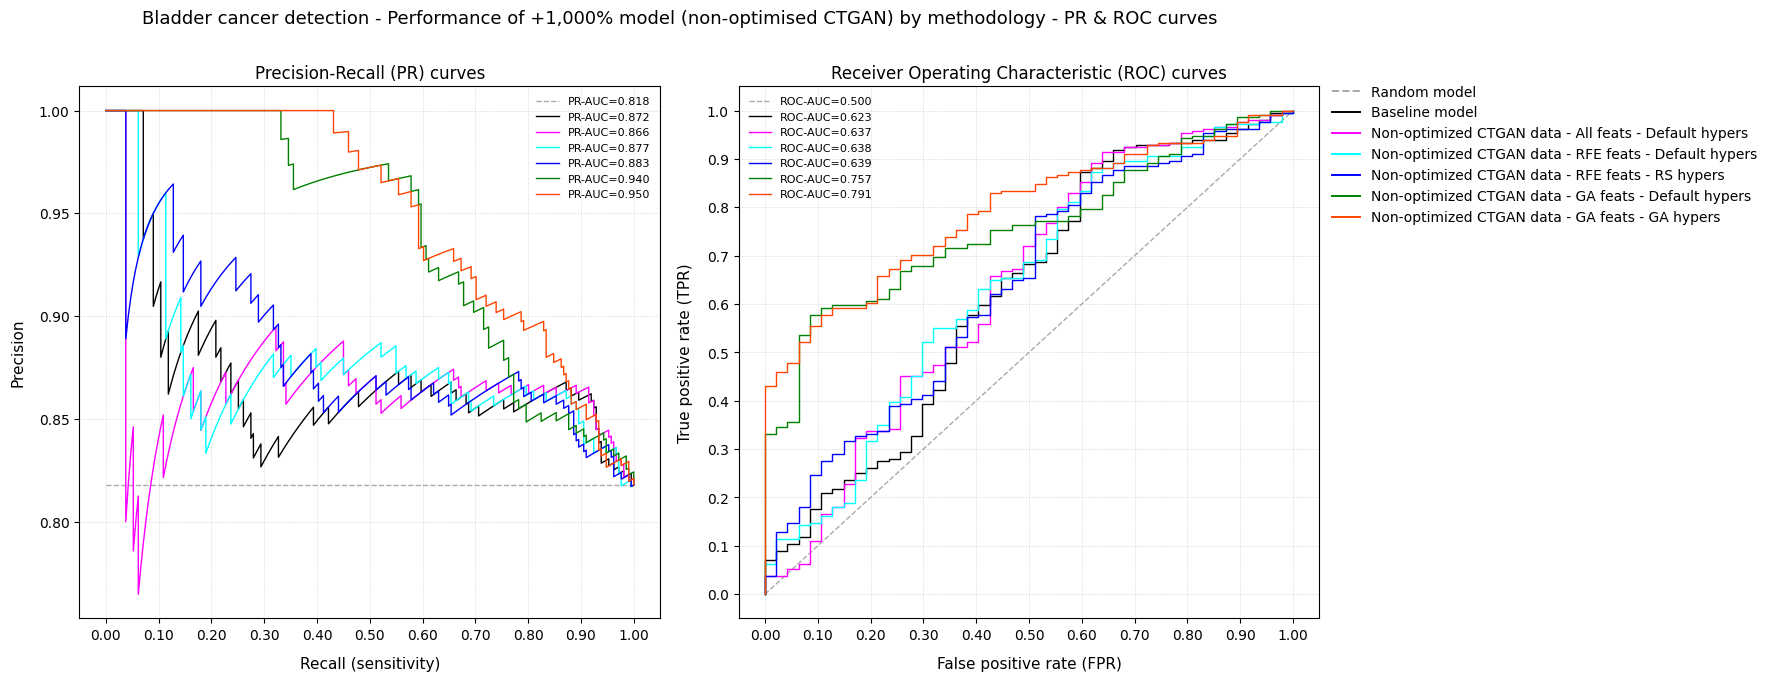

In [ ]:
########## Plot PR curves ##########

fig, axes=plt.subplots(1,2,figsize=(16,7)) # width by height

# These are in order of model complexity:

# Random model (same for all augmentation scenarios)
axes[0].plot([0, 1],
             [_1000_all_feats_pr_curve_dic['_1000']['random_model'],
             _1000_all_feats_pr_curve_dic['_1000']['random_model']],
             label=f"PR-AUC={_1000_all_feats_pr_curve_dic['_1000']['random_model']:.3f}",
             linestyle='--',
             color='darkgray',
             lw=1)

# Bal (baseline model) - model - non-optimised - all feats - default hypers
axes[0].plot(_bal_all_feats_pr_curve_dic['_bal']['recall'],
             _bal_all_feats_pr_curve_dic['_bal']['precision'],
             label=f'PR-AUC={_bal_all_feats_pr_curve_dic["_bal"]["pr_auc"]:.3f}',
             color='black',
             lw=1)

# 1000 - model - non-optimised - all feats - default hypers
axes[0].plot(_1000_all_feats_pr_curve_dic["_1000"]["recall"],
             _1000_all_feats_pr_curve_dic["_1000"]["precision"],
             label=f'PR-AUC={_1000_all_feats_pr_curve_dic["_1000"]["pr_auc"]:.3f}',
             color="magenta",
             lw=1)

# 1000 - model - non-optimised - RFE feats - default hypers
axes[0].plot(_1000_best_model_pr_curve_dic["_1000"]["recall"],
             _1000_best_model_pr_curve_dic["_1000"]["precision"],
             label=f"PR-AUC={_1000_best_model_pr_curve_dic['_1000']['pr_auc']:.3f}",
             color="cyan",
             lw=1)

# 1000 - model - non-optimised - RFE feats - RS hypers
axes[0].plot(recall,
             precision,
             label=f"PR-AUC={0.882951:.3f}",
             color="blue",
             lw=1)

# 1000 - model - non-optimised - GA feats & default hypers
axes[0].plot(pr_curve_dic_f_1000['_1000']['recall'],
             pr_curve_dic_f_1000['_1000']['precision'],
             label=f"PR-AUC={pr_curve_dic_f_1000['_1000']['pr_auc']:.3f}",
             color="green",
             lw=1)

# 1000 - model - non-optimised - GA feats & GA hypers
axes[0].plot(pr_curve_dic_fh_1000['_1000']['recall'],
             pr_curve_dic_fh_1000['_1000']['precision'],
             label=f"PR-AUC={pr_curve_dic_fh_1000['_1000']['pr_auc']:.3f}",
             color="orangered",
             lw=1)

########## ROC curve ##########

# Random model (same for all augmentation scenarios)
line1, =axes[1].plot([0, 1],
                     [0, 1],
                     label=f"ROC-AUC={0.5:.3f}",
                     linestyle='--',
                     color='darkgray',
                     lw=1)

# Bal (baseline model) - model - non-optimised - all feats - default hypers
line0, =axes[1].plot(_bal_all_feats_roc_curve_dic['_bal']['fpr'],
                     _bal_all_feats_roc_curve_dic['_bal']['tpr'],
                     label=f'ROC-AUC={_bal_all_feats_roc_curve_dic["_bal"]["roc_auc"]:.3f}',
                     color='black',
                     lw=1)

# 1000 - model - non-optimised - all feats - default hypers
line2, =axes[1].plot(_1000_all_feats_roc_curve_dic["_1000"]["fpr"],
                     _1000_all_feats_roc_curve_dic["_1000"]["tpr"],
                     label=f'ROC-AUC={_1000_all_feats_roc_curve_dic["_1000"]["roc_auc"]:.3f}',
                     color="magenta",
                     lw=1)

# 1000 - model - non-optimised - RFE feats - default hypers
line3, =axes[1].plot(_1000_best_model_roc_curve_dic["_1000"]["fpr"],
                     _1000_best_model_roc_curve_dic["_1000"]["tpr"],
                     label=f"ROC-AUC={_1000_best_model_roc_curve_dic['_1000']['roc_auc']:.3f}",
                     color="cyan",
                     lw=1)

# 1000 - model - non-optimised - RFE feats - RS hypers
line4, =axes[1].plot(fpr,
                     tpr,
                     label=f"ROC-AUC={0.638600:.3f}",
                     color="blue",
                     lw=1)

# 1000 - model - non-optimised - GA feats & default hypers
line5, =axes[1].plot(roc_curve_dic_f_1000['_1000']['fpr'],
                     roc_curve_dic_f_1000['_1000']['tpr'],
                     label=f"ROC-AUC={roc_curve_dic_f_1000['_1000']['roc_auc']:.3f}",
                     color="green",
                     lw=1)

# 1000 - model - non-optimised - GA feats & GA hypers
line6, =axes[1].plot(roc_curve_dic_fh_1000['_1000']['fpr'],
                     roc_curve_dic_fh_1000['_1000']['tpr'],
                     label=f"ROC-AUC={roc_curve_dic_fh_1000['_1000']['roc_auc']:.3f}",
                     color="orangered",
                     lw=1)

# Tidy up plots
fig.suptitle('Bladder cancer detection - Performance of +1,000% model (non-optimised CTGAN) by methodology - PR & ROC curves', fontsize=13)
fig.subplots_adjust(top=0.87, wspace=0.135)

custom_ticks = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]

axes[0].set_xticks(custom_ticks)
axes[0].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[0].set_xlabel('Recall (sensitivity)',fontsize=11,labelpad=10)
axes[0].set_ylabel('Precision',fontsize=11,labelpad=10)
axes[0].set_title('Precision-Recall (PR) curves')
axes[0].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[0].legend(loc='upper right', frameon=False, fontsize=8)

axes[1].set_xticks(custom_ticks)
axes[1].set_xticklabels([f'{tick:.2f}' for tick in custom_ticks])
axes[1].set_yticks(custom_ticks)
axes[1].set_xlabel('False positive rate (FPR)',fontsize=11,labelpad=10)
axes[1].set_ylabel('True positive rate (TPR)',fontsize=11,labelpad=10)
axes[1].set_title('Receiver Operating Characteristic (ROC) curves')
axes[1].grid(True, linestyle='--', color='lightgray', linewidth=0.36)
axes[1].legend(loc='upper left', frameon=False, fontsize=8)

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Random model'),
                       Line2D([0], [0], color=line0.get_color(), lw=1.4, label='Baseline model'),
                       Line2D([0], [0], color=line2.get_color(), lw=1.4, label='Non-optimized CTGAN data - All feats - Default hypers'),
                       Line2D([0], [0], color=line3.get_color(), lw=1.4, label='Non-optimized CTGAN data - RFE feats - Default hypers'),
                       Line2D([0], [0], color=line4.get_color(), lw=1.4, label='Non-optimized CTGAN data - RFE feats - RS hypers'),
                       Line2D([0], [0], color=line5.get_color(), lw=1.4, label='Non-optimized CTGAN data - GA feats - Default hypers'),
                       Line2D([0], [0], color=line6.get_color(), lw=1.4, label='Non-optimized CTGAN data - GA feats - GA hypers')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.90, 0.89), loc='upper left', frameon=False)

plt.show()

#### **6.2. Feature importance scores for best models**

Create one plot comparing the LGBM feature importances for each best model & the baseline model

In [ ]:
# Get importance scores for 'bal' from code IIIa
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/_bal_all_feats_model', 'rb') as file:
    _bal_all_feats_model=pickle.load(file)
data=list(zip(_bal_all_feats_model['feat_names'], _bal_all_feats_model['feat_imp']))
feat_imp_bal=pd.DataFrame(data, columns=['Feature', 'Importance'])
#feat_imp_bal=feat_imp_bal.drop(32).reset_index(drop=True)

# Get importance scores for _50_o and _1000 from ad hoc pieces of code in IIIb
feat_imp_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl').reset_index(drop=True)
feat_imp_fh_50_o=feat_imp_fh_50_o.drop(15).reset_index(drop=True)
feat_imp_fh_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000.pkl').reset_index(drop=True)

# Bring together into one dataframe
df1=pd.merge(feat_imp_bal.rename(columns={'Importance':'_bal_imp'}), feat_imp_fh_50_o.rename(columns={'Importance':'_50_imp'}),on='Feature',how='outer')
df2=pd.merge(df1,feat_imp_fh_1000.rename(columns={'Importance':'_1000_imp'}),on='Feature',how='outer')
df3=df2.sort_values(by='Feature',ascending=True).reset_index(drop=True)

# Transform importance values (>0) to enable easy plotting
df3[['_bal_imp_log','_50_imp_log','_1000_imp_log']]=np.log1p(df3[['_bal_imp','_50_imp','_1000_imp']])

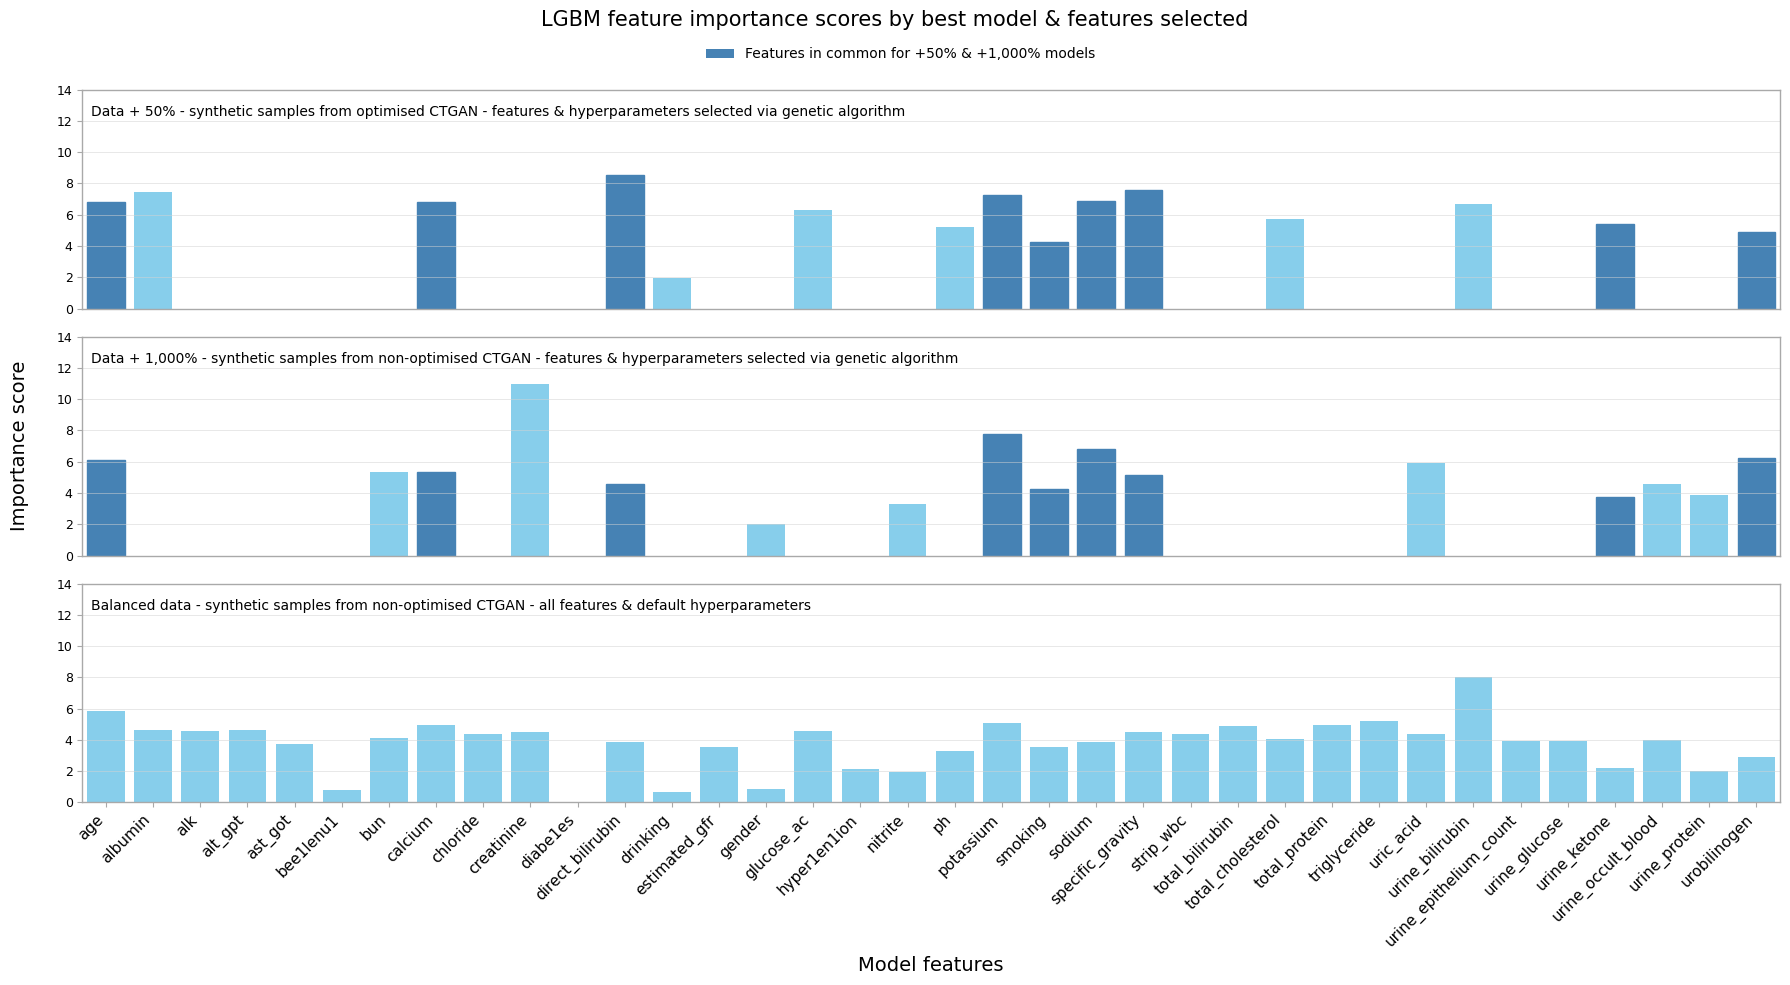

In [ ]:
# Plot feature importances

fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

plot1=axes[0].bar(df3['Feature'], df3['_50_imp_log'],   color='skyblue')
plot2=axes[1].bar(df3['Feature'], df3['_1000_imp_log'], color='skyblue')
plot3=axes[2].bar(df3['Feature'], df3['_bal_imp_log'],  color='skyblue')

# Colour bars which are common to two subsetted models
for i in [plot1, plot2]:
  i[0].set_color('steelblue')
  i[7].set_color('steelblue')
  i[11].set_color('steelblue')
  i[19].set_color('steelblue')
  i[20].set_color('steelblue')
  i[21].set_color('steelblue')
  i[22].set_color('steelblue')
  i[32].set_color('steelblue')
  i[35].set_color('steelblue')

# Tidy up plot

# Add main title
fig.suptitle('LGBM feature importance scores by best model & features selected', fontsize=15)

# Manually add titles for each plot
axes[0].text(0.005, 0.88, 'Data + 50% - synthetic samples from optimised CTGAN - features & hyperparameters selected via genetic algorithm', transform=axes[0].transAxes, fontsize=10)
axes[1].text(0.005, 0.88, 'Data + 1,000% - synthetic samples from non-optimised CTGAN - features & hyperparameters selected via genetic algorithm', transform=axes[1].transAxes, fontsize=10)
axes[2].text(0.005, 0.88, 'Balanced data - synthetic samples from non-optimised CTGAN - all features & default hyperparameters', transform=axes[2].transAxes, fontsize=10)

# Set axes title
axes[-1].set_xlabel('Model features', fontsize=14)
axes[1].set_ylabel('Importance score', labelpad=20, fontsize=14)

# Format x-tick labels
axes[2].tick_params(axis='x',rotation=45, labelsize=11)
axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right')

# Format y-tick labels
axes[0].tick_params(axis='y', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)
axes[2].tick_params(axis='y', labelsize=9)
for ax in axes:
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])

# Add gridlines
for ax in axes:
    ax.grid(True, axis='y', color='lightgray', linewidth=0.36)

# Set the border color for each subplot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('darkgray')
        spine.set_linewidth(1)

# Set the color of y-axis tick marks
for ax in axes:
     ax.tick_params(axis='x', color='darkgray')
     ax.tick_params(axis='y', color='darkgray')

# Remove x-axis tick marks for top two plots
axes[0].tick_params(axis='x', bottom=False, top=False, left=False, right=False)
axes[1].tick_params(axis='x', bottom=False, top=False, left=False, right=False)

# Remove excess space at both ends of plot
axes[2].set_xlim(-0.5, len(df3['Feature']) - 0.5)

# Add manual legend
legend_elements=[Patch(facecolor='steelblue', edgecolor='None', label='Features in common for +50% & +1,000% models')]

# Add legend to the first subplot outside the plot area
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.36, 1.25), frameon=False, fontsize=10)

# # Fix - remove gray coloring of plots
# for ax in axes:
#     ax.set_facecolor('white')

plt.tight_layout()
plt.show()

#### **6.3. Feature correlations - real vs. augmented**

CAN USE THIS IN-CONJUNCTION WITH THE OUTPUTS IN CTGAN CODES (IIa & IIb)

- Use Spearman rank correlations as per previous analyses to compare the monotonicity relationships occurring in the synthetic data of the augmented datasets used in the models with that of the real data. Note:
 - Spearman rank measures the monotonic relationship between two variables (whether the relationship is strictly increasing or decreasing)
 - It does not assume linearity or normal distribution
 - It is less sensitive to outliers than Pearson correlation
 - It is suitable for both continuous and ordinal (rank-ordered)
- To make the heatmaps readable only consider the features used in each model
- Can only consider numeric features
- As opposed to the work in IIa & IIb where the fidelity of synthetic samples of each augmentation scenario was compared to that of real samples, here will consider all types of samples in the augmented data - real & synthetic - as this is what the practioner will be using
- For categorical features will compare value distributions of real versus synthetic samples
- Also looked at Euclidean distance (calculated via Frobenius norm) between the real and augmented dataframes of correlation coefficients (see below)


##### **6.3.1. Get real data & prepare ahead of correlation calculation**

In [ ]:
# Get cleaned original training data
df=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_imp.pkl')

# Reformat target and other selected features to categorical
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df[i]=df[i].astype('category')

# To avoid generation of synthetic samples with negative values transform the data
num_cols=df.select_dtypes(include='number').columns
df_t=df.copy()
df_t=df[num_cols].applymap(lambda x:np.log(x+100)) # Smaller increments than 100 result in some negative values in synthetic samples
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df_t[i]=df[i]

# Get list of numeric features
num_cols=list(df_t.select_dtypes(include='float64').columns)

# Separate out the two classes into separate datasets
real_0=df_t.loc[df_t['disease1']==0]
real_1=df_t.loc[df_t['disease1']==1]

##### **6.3.2. Continuous features**

 Get augmented data - subset to features used in respective models - separate out into the two classes

In [ ]:
##### _bal #####

bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl')
bal_cols=list(feat_imp_bal['Feature'])
bal_cols.append('disease1')
bal_a=bal[bal_cols]
# Separate into class & sort columns into alphabetical order
bal_0=bal_a.loc[bal_a['disease1']==0].sort_index(axis=1)
bal_1=bal_a.loc[bal_a['disease1']==1].sort_index(axis=1)

# Subset real data subsetted to the same features & sort columns into alphabetical order
real_0_bal=real_0[bal_cols].sort_index(axis=1)
real_1_bal=real_1[bal_cols].sort_index(axis=1)

##### _50_o #####

_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl')
_50_cols=list(feat_imp_fh_50_o['Feature'])
_50_cols.append('disease1')
_50_a=_50[_50_cols]
# Separate into class & sort columns into alphabetical order
_50_0=_50_a.loc[_50_a['disease1']==0].sort_index(axis=1)
_50_1=_50_a.loc[_50_a['disease1']==1].sort_index(axis=1)

# Subset real data subsetted to the same features & sort columns into alphabetical order
real_0_50=real_0[_50_cols].sort_index(axis=1)
real_1_50=real_1[_50_cols].sort_index(axis=1)

##### _1000 #####

_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl')
_1000_cols=list(feat_imp_fh_1000['Feature'])
_1000_cols.append('disease1')
_1000_a=_1000[_1000_cols]
# Separate into class & sort columns into alphabetical order
_1000_0=_1000_a.loc[_1000_a['disease1']==0].sort_index(axis=1)
_1000_1=_1000_a.loc[_1000_a['disease1']==1].sort_index(axis=1)

# Subset real data subsetted to the same features & sort columns into alphabetical order
real_0_1000=real_0[_1000_cols].sort_index(axis=1)
real_1_1000=real_1[_1000_cols].sort_index(axis=1)

Plot matrices for class 0 (non-bladder cancer) samples - real vs augmented

In [ ]:
# Set up subplots
fig, axes=plt.subplots(3,2,figsize=(60,80),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - Real data vs. augmented data - Class 0 (non-bladder cancer)\n(-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=50,y=1.03)

# The corr() method only considers numeric features by default so no need to remove categorical features from datasets

# Real vs bal
corr_0a=real_0_bal.corr(method='spearman')
heatmap_plot(corr_0a,'Real data',0,0,24)
corr_0b=bal_0.corr(method='spearman')
heatmap_plot(corr_0b,'Balanced data',0,1,24)

# Real vs _50_o
corr_0c=real_0_50.corr(method='spearman')
heatmap_plot(corr_0c,'Real data',1,0,38)
corr_0d=_50_0.corr(method='spearman')
heatmap_plot(corr_0d,'+50% data',1,1,38)

# Real vs _1000
corr_0e=real_0_1000.corr(method='spearman')
heatmap_plot(corr_0e,'Real data',2,0,38)
corr_0f=_1000_0.corr(method='spearman')
heatmap_plot(corr_0f,'+1,000% data',2,1,38)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Plot matrices for class 1 (bladder cancer) samples - real vs augmented

In [ ]:
# Set up subplots
fig, axes=plt.subplots(3,2,figsize=(60,80),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - Real data vs. augmented data - Class 1 (bladder cancer)\n(-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=50,y=1.03)

# The corr() method only considers numeric features by default so no need to remove categorical features from datasets

# Real vs bal
corr_1a=real_1_bal.corr(method='spearman')
heatmap_plot(corr_1a,'Real data',0,0,24)
corr_1b=bal_1.corr(method='spearman')
heatmap_plot(corr_1b,'Balanced data',0,1,24)

# Real vs _50_o
corr_1c=real_1_50.corr(method='spearman')
heatmap_plot(corr_1c,'Real data',1,0,38)
corr_1d=_50_1.corr(method='spearman')
heatmap_plot(corr_1d,'+50% data',1,1,38)

# Real vs _1000
corr_1e=real_1_1000.corr(method='spearman')
heatmap_plot(corr_1e,'Real data',2,0,38)
corr_1f=_1000_1.corr(method='spearman')
heatmap_plot(corr_1f,'+1,000% data',2,1,38)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### **6.3.3. Calculate the Euclidean distances betwee real & augmented correlation matrices**
- Calculate the Euclidean distance between each respective row pair from the real data correlation matrix & the augmented data correlation matrix
- Smaller distances means greater similarity in correlation scores while larger distances means greater dissimilarity  in correlation scores
- Calculate the overall average distance for all of the row pairs


In [ ]:
# Class 0 - 'non-bladder cancer'

eucl_0_dic={'Real vs balanced':round(np.mean(euclidean_distance2(corr_0a, corr_0b)),3),
            'Real vs augmented 50% - optimised':round(np.mean(euclidean_distance2(corr_0c, corr_0d)),3),
            'Real vs augmented 1000% - non-optimised':round(np.mean(euclidean_distance2(corr_0e, corr_0f)),3)}

# Class 1 - 'non-bladder cancer'

eucl_1_dic={'Real vs balanced':round(np.mean(euclidean_distance2(corr_1a, corr_1b)),3),
            'Real vs augmented 50% - optimised':round(np.mean(euclidean_distance2(corr_1c, corr_1d)),3),
            'Real vs augmented 1000% - non-optimised':round(np.mean(euclidean_distance2(corr_1e, corr_1f)),3)}

# Bring together both into a df
df_eucl_0=pd.DataFrame(list(eucl_0_dic.items()),columns=['Comparison', 'Non-BC mean Eucl. distance'])
df_eucl_1=pd.DataFrame(list(eucl_1_dic.items()),columns=['Comparison', 'BC mean Eucl. distance'])

# Merge DataFrames on the 'Comparison' column
df_eucl=pd.merge(df_eucl_0,df_eucl_1,on='Comparison')

# Display the merged DataFrame
df_eucl

,Comparison,Non-BC mean Eucl. distance,BC mean Eucl. distance
0,Real vs balanced,2.489,0.285
1,Real vs augmented 50% - optimised,0.652,1.114
2,Real vs augmented 1000% - non-optimised,0.848,0.934


Appears as though the augmented data provides better fidelity than for balanced data for Non-BC but the converse is true for BC

##### **6.3.4. Categorical features**

In [ ]:
# Datasets to use:

# real_0
# real_1
# bal_0
# bal_1
# _50_0
# _50_1
# _1000_0
# _1000_1

# df_t       # Real training data - log transformed
# aug_balu   # Balanced training data - log transformed - non-optimised CTGAN
# aug_50     # Augmented training data +50% - log transformed - optimised CTGAN
# aug_1000u  # Augmented training data +1000% - log transformed - non-optimised CTGAN

In [ ]:
# Categorical features in each:

# real_0 & real_1
# gender
# hyper1en1ion
# diabe1es       # This feature does not appear in _50_o or _1000 models & has a fetaure importance of near zero for balanced model (all features). So do not consider it in this analysis
# smoking
# drinking
# bee1lenu1
# disease1       # Can ignore as set to 50:50 in bal, _50_o & _1000

# bal_0 & bal_1
# bee1lenu1
# disease1
# drinking
# gender
# hyper1en1ion
# smoking

# _50_0 & _50_1
# disease1
# drinking
# smoking

# _1000_0 & _1000_1
# disease1
# gender
# smoking

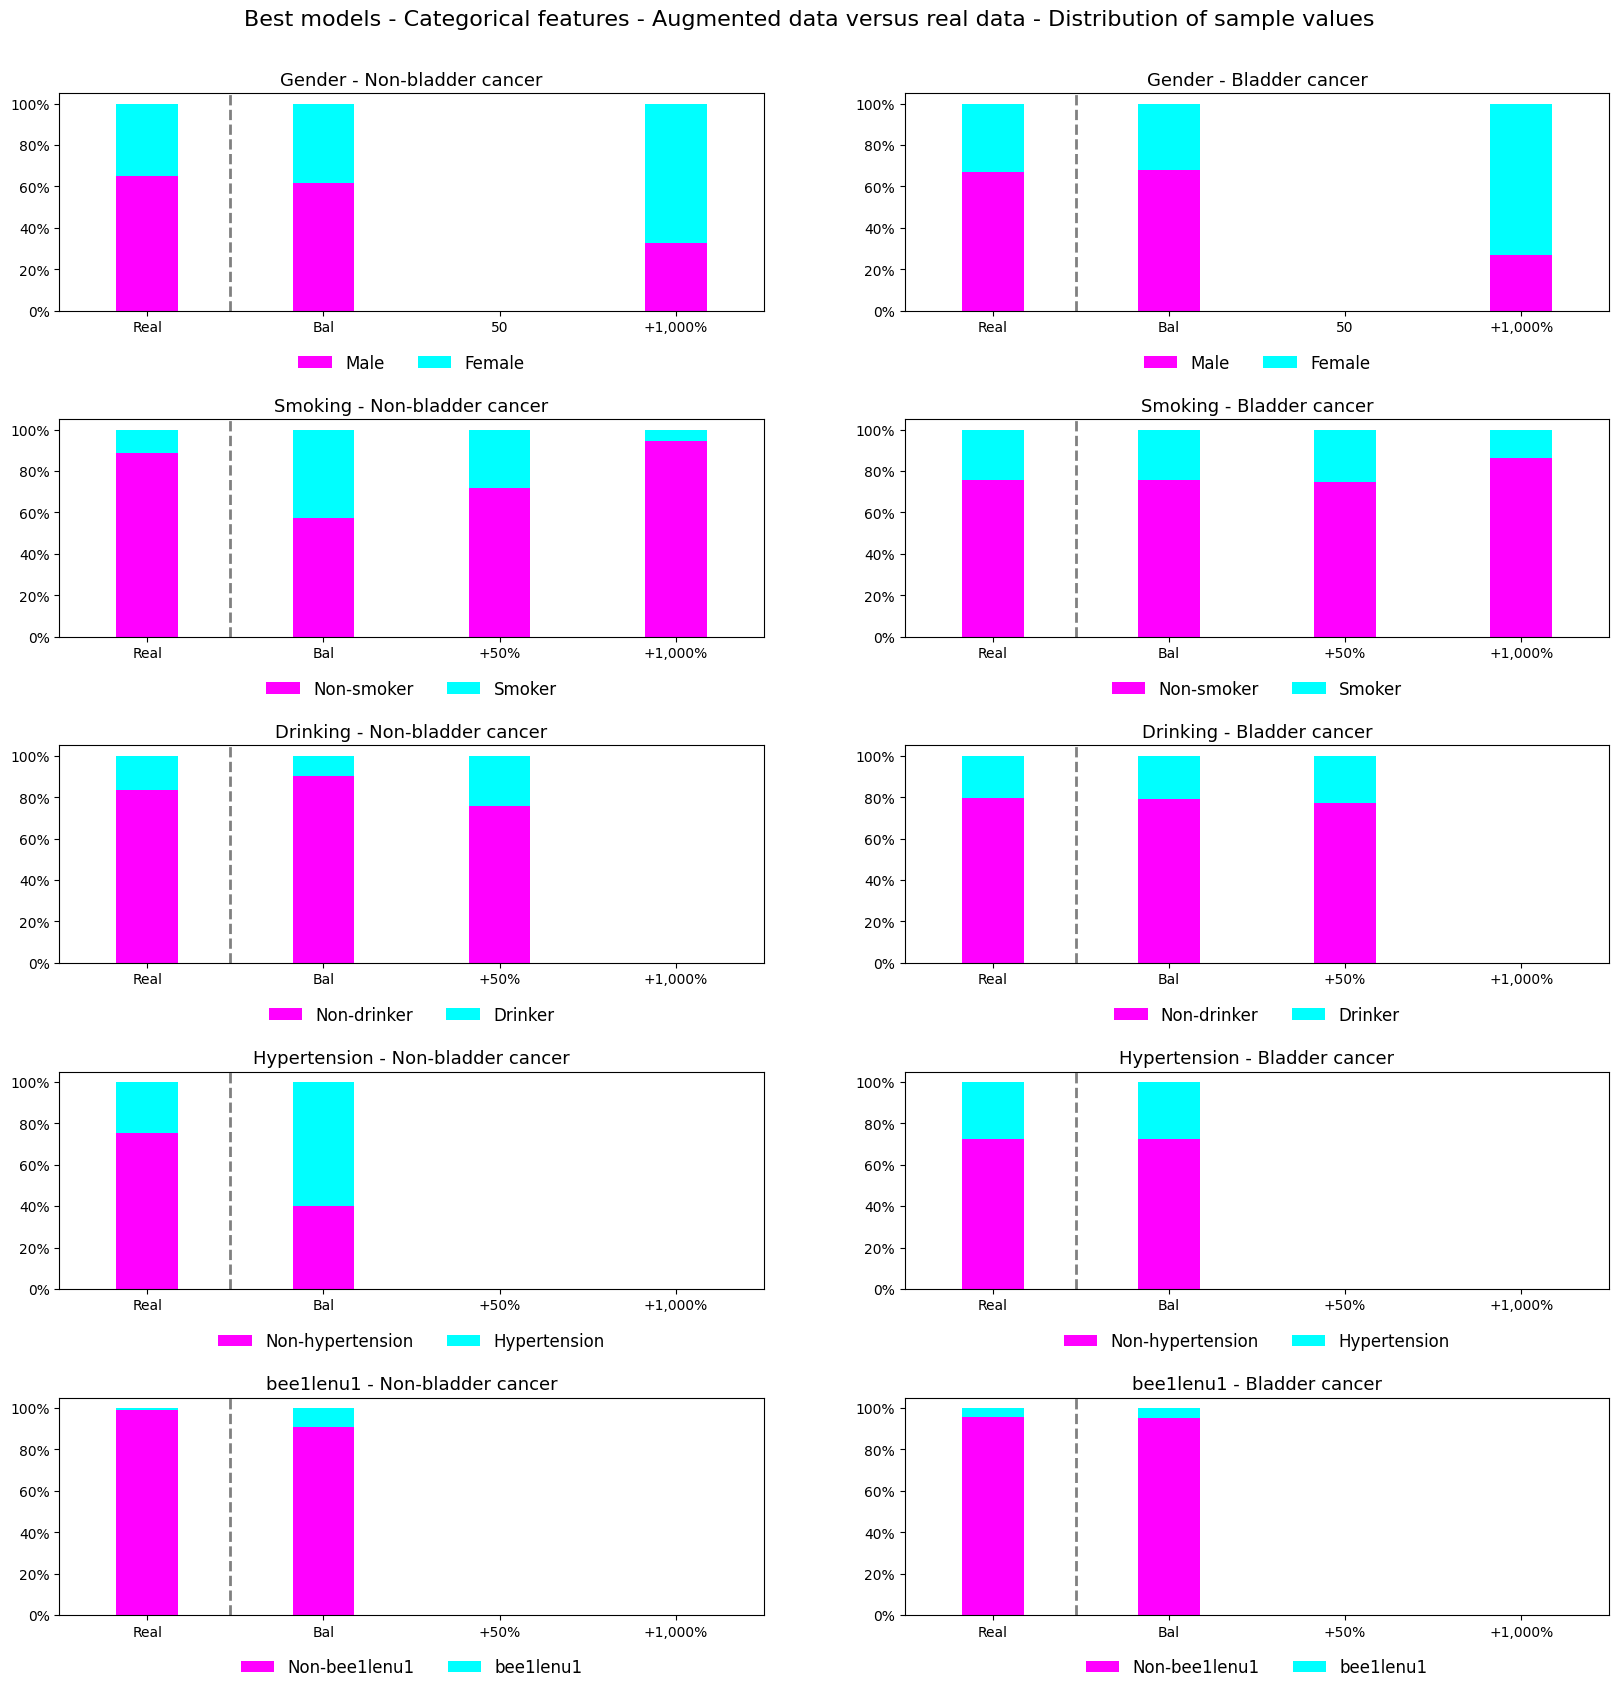

In [ ]:
# Set up subplots
fig, axes=plt.subplots(6,2,figsize=(20,24),gridspec_kw={'hspace': 0.5})

# Over-arching title of all plots
fig.suptitle('Best models - Categorical features - Augmented data versus real data - Distribution of sample values',fontsize=16, y=0.915)

########## Gender ##########

# Real
act_0=real_0['gender'].value_counts(dropna=False,normalize=True)
act_0a=pd.DataFrame({'gender': act_0.index,'NonBC:Real':act_0.values})
act_1=real_1['gender'].value_counts(dropna=False,normalize=True)
act_1a=pd.DataFrame({'gender': act_1.index,'BC:Real':act_1.values})

# Bal
synth_0=bal_0['gender'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'gender': synth_0.index,'NonBC:Bal':synth_0.values})
synth_1=bal_1['gender'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'gender': synth_1.index,'BC:Bal':synth_1.values})
# Merge into one dataframe
all1=pd.merge(act_0a,act_1a,on='gender')
all2=pd.merge(all1,synth_0a,on='gender')
all3=pd.merge(all2,synth_1a,on='gender')

# 1000
synth_0=_1000_0['gender'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'gender': synth_0.index,'NonBC:1000':synth_0.values})
synth_1=_1000_1['gender'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'gender': synth_1.index,'BC:1000':synth_1.values})
# Merge into one dataframe
all4=pd.merge(all3,synth_0a,on='gender')
all5=pd.merge(all4,synth_1a,on='gender')

# Populate missing scenarios in df
all5['NonBC:50']=None
all5['BC:50']=None

# Rearrange dataframe so that non-BC and BC columns are grouped together
all6=all5[['gender','NonBC:Real','NonBC:Bal','NonBC:50','NonBC:1000','BC:Real','BC:Bal','BC:50','BC:1000']]
# Split into non-BC and BC datasets
all_non_bc=all6[['gender','NonBC:Real','NonBC:Bal','NonBC:50','NonBC:1000']]
all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:Bal':'Bal','NonBC:50':'50','NonBC:1000':'+1,000%'},inplace=True)
all_bc=all6[['gender','BC:Real','BC:Bal','BC:50','BC:1000']]
all_bc.rename(columns={'BC:Real':'Real','BC:Bal':'Bal','BC:50':'50','BC:1000':'+1,000%'},inplace=True)
# Reshape data for plotting
all_non_bc1=all_non_bc.T
all_non_bc1.columns=['Male','Female']
all_non_bc1=all_non_bc1[1:]
all_bc1=all_bc.T
all_bc1.columns=['Male','Female']
all_bc1=all_bc1[1:]

# Plot feature distributions
# Non-BC
all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[0,0],width=0.35)
axes[0,0].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[0,0].yaxis.set_major_formatter(formatter)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(),rotation=0,fontsize=10)
axes[0,0].set_title('Gender'+' - Non-bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Male'),
                mpatches.Patch(facecolor='cyan',label='Female')]
axes[0,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[0,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[0,0].set_xlim(-0.5,4-0.5)
# BC
all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[0,1],width=0.35)
axes[0,1].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[0,1].yaxis.set_major_formatter(formatter)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(),rotation=0,fontsize=10)
axes[0,1].set_title('Gender'+' - Bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Male'),
                mpatches.Patch(facecolor='cyan',label='Female')]
axes[0,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[0,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[0,1].set_xlim(-0.5,4-0.5)

########## Smoking ##########

# Real
act_0=real_0['smoking'].value_counts(dropna=False,normalize=True)
act_0a=pd.DataFrame({'smoking': act_0.index,'NonBC:Real':act_0.values})
act_1=real_1['smoking'].value_counts(dropna=False,normalize=True)
act_1a=pd.DataFrame({'smoking': act_1.index,'BC:Real':act_1.values})

# Bal
synth_0=bal_0['smoking'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'smoking': synth_0.index,'NonBC:Bal':synth_0.values})
synth_1=bal_1['smoking'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'smoking': synth_1.index,'BC:Bal':synth_1.values})
# Merge into one dataframe
all1=pd.merge(act_0a,act_1a,on='smoking')
all2=pd.merge(all1,synth_0a,on='smoking')
all3=pd.merge(all2,synth_1a,on='smoking')

# 50
synth_0=_50_0['smoking'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'smoking': synth_0.index,'NonBC:50':synth_0.values})
synth_1=_50_1['smoking'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'smoking': synth_1.index,'BC:50':synth_1.values})
# Merge into one dataframe
all4=pd.merge(all3,synth_0a,on='smoking')
all5=pd.merge(all4,synth_1a,on='smoking')

# 1000
synth_0=_1000_0['smoking'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'smoking': synth_0.index,'NonBC:1000':synth_0.values})
synth_1=_1000_1['smoking'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'smoking': synth_1.index,'BC:1000':synth_1.values})
# Merge into one dataframe
all6=pd.merge(all5,synth_0a,on='smoking')
all7=pd.merge(all6,synth_1a,on='smoking')

# Rearrange dataframe so that non-BC and BC columns are grouped together
all8 = all7[['smoking', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000', 'BC:Real', 'BC:Bal', 'BC:50', 'BC:1000']]
# Split into non-BC and BC datasets
all_non_bc = all8[['smoking', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000']]
all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:Bal':'Bal','NonBC:50':'+50%','NonBC:1000':'+1,000%'},inplace=True)
all_bc=all8[['smoking','BC:Real','BC:Bal','BC:50','BC:1000']]
all_bc.rename(columns={'BC:Real':'Real','BC:Bal':'Bal','BC:50':'+50%','BC:1000':'+1,000%'},inplace=True)
# Reshape data for plotting
all_non_bc1=all_non_bc.T
all_non_bc1.columns=['Non-smoker','Smoker']
all_non_bc1=all_non_bc1[1:]
all_bc1=all_bc.T
all_bc1.columns=['Non-smoker','Smoker']
all_bc1=all_bc1[1:]

# Plot feature distributions
# Non-BC
all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[1,0],width=0.35)
axes[1,0].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[1,0].yaxis.set_major_formatter(formatter)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(),rotation=0,fontsize=10)
axes[1,0].set_title('Smoking'+' - Non-bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-smoker'),
                mpatches.Patch(facecolor='cyan',label='Smoker')]
axes[1,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[1,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[1,0].set_xlim(-0.5,4-0.5)
# BC
all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[1,1],width=0.35)
axes[1,1].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[1,1].yaxis.set_major_formatter(formatter)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(),rotation=0,fontsize=10)
axes[1,1].set_title('Smoking'+' - Bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-smoker'),
                mpatches.Patch(facecolor='cyan',label='Smoker')]
axes[1,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[1,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[1,1].set_xlim(-0.5,4-0.5)

########## Drinking ##########

# Real
act_0=real_0['drinking'].value_counts(dropna=False,normalize=True)
act_0a=pd.DataFrame({'drinking': act_0.index,'NonBC:Real':act_0.values})
act_1=real_1['drinking'].value_counts(dropna=False,normalize=True)
act_1a=pd.DataFrame({'drinking': act_1.index,'BC:Real':act_1.values})

# Bal
synth_0=bal_0['drinking'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'drinking': synth_0.index,'NonBC:Bal':synth_0.values})
synth_1=bal_1['drinking'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'drinking': synth_1.index,'BC:Bal':synth_1.values})
# Merge into one dataframe
all1=pd.merge(act_0a,act_1a,on='drinking')
all2=pd.merge(all1,synth_0a,on='drinking')
all3=pd.merge(all2,synth_1a,on='drinking')

# 50
synth_0=_50_0['drinking'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'drinking': synth_0.index,'NonBC:50':synth_0.values})
synth_1=_50_1['drinking'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'drinking': synth_1.index,'BC:50':synth_1.values})
# Merge into one dataframe
all4=pd.merge(all3,synth_0a,on='drinking')
all5=pd.merge(all4,synth_1a,on='drinking')

# Populate missing scenarios in df
all5['NonBC:1000']=None
all5['BC:1000']=None

# Rearrange dataframe so that non-BC and BC columns are grouped together
all8 = all5[['drinking', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000', 'BC:Real', 'BC:Bal', 'BC:50', 'BC:1000']]
# Split into non-BC and BC datasets
all_non_bc = all8[['drinking', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000']]
all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:Bal':'Bal','NonBC:50':'+50%','NonBC:1000':'+1,000%'},inplace=True)
all_bc=all8[['drinking','BC:Real','BC:Bal','BC:50','BC:1000']]
all_bc.rename(columns={'BC:Real':'Real','BC:Bal':'Bal','BC:50':'+50%','BC:1000':'+1,000%'},inplace=True)
# Reshape data for plotting
all_non_bc1=all_non_bc.T
all_non_bc1.columns=['Non-drinker','Drinker']
all_non_bc1=all_non_bc1[1:]
all_bc1=all_bc.T
all_bc1.columns=['Non-drinker','Drinker']
all_bc1=all_bc1[1:]

# Plot feature distributions
# Non-BC
all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[2,0],width=0.35)
axes[2,0].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[2,0].yaxis.set_major_formatter(formatter)
axes[2,0].set_xticklabels(axes[2,0].get_xticklabels(),rotation=0,fontsize=10)
axes[2,0].set_title('Drinking'+' - Non-bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-drinker'),
                mpatches.Patch(facecolor='cyan',label='Drinker')]
axes[2,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[2,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[2,0].set_xlim(-0.5,4-0.5)
# BC
all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[2,1],width=0.35)
axes[2,1].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[2,1].yaxis.set_major_formatter(formatter)
axes[2,1].set_xticklabels(axes[2,1].get_xticklabels(),rotation=0,fontsize=10)
axes[2,1].set_title('Drinking'+' - Bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-drinker'),
                mpatches.Patch(facecolor='cyan',label='Drinker')]
axes[2,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[2,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[2,1].set_xlim(-0.5,4-0.5)

########## Hypertension ##########

# Real
act_0=real_0['hyper1en1ion'].value_counts(dropna=False,normalize=True)
act_0a=pd.DataFrame({'hyper1en1ion': act_0.index,'NonBC:Real':act_0.values})
act_1=real_1['hyper1en1ion'].value_counts(dropna=False,normalize=True)
act_1a=pd.DataFrame({'hyper1en1ion': act_1.index,'BC:Real':act_1.values})

# Bal
synth_0=bal_0['hyper1en1ion'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'hyper1en1ion': synth_0.index,'NonBC:Bal':synth_0.values})
synth_1=bal_1['hyper1en1ion'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'hyper1en1ion': synth_1.index,'BC:Bal':synth_1.values})
# Merge into one dataframe
all1=pd.merge(act_0a,act_1a,on='hyper1en1ion')
all2=pd.merge(all1,synth_0a,on='hyper1en1ion')
all3=pd.merge(all2,synth_1a,on='hyper1en1ion')

# Populate missing scenarios in df
all3['NonBC:50']=None
all3['BC:50']=None
all3['NonBC:1000']=None
all3['BC:1000']=None

# Rearrange dataframe so that non-BC and BC columns are grouped together
all6=all3[['hyper1en1ion','NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000', 'BC:Real', 'BC:Bal', 'BC:50', 'BC:1000']]
# Split into non-BC and BC datasets
all_non_bc=all6[['hyper1en1ion', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000']]
all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:Bal':'Bal','NonBC:50':'+50%','NonBC:1000':'+1,000%'},inplace=True)
all_bc=all6[['hyper1en1ion','BC:Real','BC:Bal','BC:50','BC:1000']]
all_bc.rename(columns={'BC:Real':'Real','BC:Bal':'Bal','BC:50':'+50%','BC:1000':'+1,000%'},inplace=True)
# Reshape data for plotting
all_non_bc1=all_non_bc.T
all_non_bc1.columns=['Non-hypertension','Hypertension']
all_non_bc1=all_non_bc1[1:]
all_bc1=all_bc.T
all_bc1.columns=['Non-hypertension','Hypertension']
all_bc1=all_bc1[1:]

# Plot feature distributions
# Non-BC
all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[3,0],width=0.35)
axes[3,0].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[3,0].yaxis.set_major_formatter(formatter)
axes[3,0].set_xticklabels(axes[3,0].get_xticklabels(),rotation=0,fontsize=10)
axes[3,0].set_title('Hypertension'+' - Non-bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-hypertension'),
                mpatches.Patch(facecolor='cyan',label='Hypertension')]
axes[3,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[3,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[3,0].set_xlim(-0.5,4-0.5)
# BC
all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[3,1],width=0.35)
axes[3,1].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[3,1].yaxis.set_major_formatter(formatter)
axes[3,1].set_xticklabels(axes[3,1].get_xticklabels(),rotation=0,fontsize=10)
axes[3,1].set_title('Hypertension'+' - Bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-hypertension'),
                mpatches.Patch(facecolor='cyan',label='Hypertension')]
axes[3,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[3,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[3,1].set_xlim(-0.5,4-0.5)

########## bee1lenu1 ##########

# Real
act_0=real_0['bee1lenu1'].value_counts(dropna=False,normalize=True)
act_0a=pd.DataFrame({'bee1lenu1': act_0.index,'NonBC:Real':act_0.values})
act_1=real_1['bee1lenu1'].value_counts(dropna=False,normalize=True)
act_1a=pd.DataFrame({'bee1lenu1': act_1.index,'BC:Real':act_1.values})

# Bal
synth_0=bal_0['bee1lenu1'].value_counts(dropna=False,normalize=True)
synth_0a=pd.DataFrame({'bee1lenu1': synth_0.index,'NonBC:Bal':synth_0.values})
synth_1=bal_1['bee1lenu1'].value_counts(dropna=False,normalize=True)
synth_1a=pd.DataFrame({'bee1lenu1': synth_1.index,'BC:Bal':synth_1.values})
# Merge into one dataframe
all1=pd.merge(act_0a,act_1a,on='bee1lenu1')
all2=pd.merge(all1,synth_0a,on='bee1lenu1')
all3=pd.merge(all2,synth_1a,on='bee1lenu1')

# Populate missing scenarios in df
all3['NonBC:50']=None
all3['BC:50']=None
all3['NonBC:1000']=None
all3['BC:1000']=None

# Rearrange dataframe so that non-BC and BC columns are grouped together
all6=all3[['bee1lenu1','NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000', 'BC:Real', 'BC:Bal', 'BC:50', 'BC:1000']]
# Split into non-BC and BC datasets
all_non_bc=all6[['bee1lenu1', 'NonBC:Real', 'NonBC:Bal', 'NonBC:50', 'NonBC:1000']]
all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:Bal':'Bal','NonBC:50':'+50%','NonBC:1000':'+1,000%'},inplace=True)
all_bc=all6[['bee1lenu1','BC:Real','BC:Bal','BC:50','BC:1000']]
all_bc.rename(columns={'BC:Real':'Real','BC:Bal':'Bal','BC:50':'+50%','BC:1000':'+1,000%'},inplace=True)
# Reshape data for plotting
all_non_bc1=all_non_bc.T
all_non_bc1.columns=['Non-bee1lenu1','bee1lenu1']
all_non_bc1=all_non_bc1[1:]
all_bc1=all_bc.T
all_bc1.columns=['Non-bee1lenu1','bee1lenu1']
all_bc1=all_bc1[1:]

# Plot feature distributions
# Non-BC
all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[4,0],width=0.35)
axes[4,0].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[4,0].yaxis.set_major_formatter(formatter)
axes[4,0].set_xticklabels(axes[4,0].get_xticklabels(),rotation=0,fontsize=10)
axes[4,0].set_title('bee1lenu1'+' - Non-bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-bee1lenu1'),
                mpatches.Patch(facecolor='cyan',label='bee1lenu1')]
axes[4,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[4,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[4,0].set_xlim(-0.5,4-0.5)
# BC
all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[4,1],width=0.35)
axes[4,1].tick_params(axis='y',labelsize=10)
formatter=FuncFormatter(percentage_formatter)
axes[4,1].yaxis.set_major_formatter(formatter)
axes[4,1].set_xticklabels(axes[4,1].get_xticklabels(),rotation=0,fontsize=10)
axes[4,1].set_title('bee1lenu1'+' - Bladder cancer',fontsize=13)
legend_handles=[mpatches.Patch(facecolor='magenta',label='Non-bee1lenu1'),
                mpatches.Patch(facecolor='cyan',label='bee1lenu1')]
axes[4,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=12)
axes[4,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)
axes[4,1].set_xlim(-0.5,4-0.5)

fig.delaxes(axes[5,0])
fig.delaxes(axes[5,1])

plt.tight_layout()
plt.show()

#### **6.4. Probability score threshold analysis**

- Experiment with different threshold cut-offs for performance evaluation
- To undertake this analysis need to recreate the probability predictions for the test data for each model - as these were not saved. Because of their stochastic nature re-running the models on same features and hyperparameters may produce some small variation in the results when compared to previous model builds
- Consider 1,000 threshold increments between 0 & 1 and calculate all the key performance metrics (threshold invariant & variant)
- Try cut-ofs based on balancing precision & recall, sensitivity & specificity and assignment based on maximum class probabilty (i.e. probability score > 0.50 is assigned to class 1)
- Then review them and decide on best threshold cut-off (consider published results)

**+50% - Optimised CTGAN - GA feats & hypers**

In [ ]:
##### Get GA feats & GA hypers ####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o','rb') as file:
    hypers=pickle.load(file)

##### Get optimised training data & hold out data #####

x_train, y_train, x_test, y_test, _=data_prep('_50_o','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Repeat the build process to get probability scores #####

y_pred=build_model(hypers, feats, x_train, y_train, x_test)

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_50_o.pkl')
# Download performance metrics
threshold_analysis_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_50_o.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.278
4. Best ROC curve threshold : 0.944
5. Maximising F1 score threshold : 0.986
6. Bal SS threshold : 0.944
7. Perf score similarity - Tsai : 0.92
8. Perf score similarity - Shih : 0.943


In [ ]:
threshold_analysis_50_o

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.500,0.900474,0.833333,0.191489,0.865604,0.771318,0.947915,0.780478
1,prior pop prob,0.797,0.838863,0.867647,0.425532,0.853012,0.763566,0.947915,0.780478
2,"closest pt on pr curve to [1,1]",0.278,0.957346,0.831276,0.127660,0.889868,0.806202,0.947915,0.780478
3,maximise f1 score,0.986,0.459716,0.989796,0.978723,0.627832,0.554264,0.947915,0.780478
4,perf metrics similarity - tsai,0.920,0.715640,0.926380,0.744681,0.807487,0.720930,0.947915,0.780478
5,perf metrics similarity - shih,0.943,0.677725,0.947020,0.829787,0.790055,0.705426,0.947915,0.780478
6,"closest pt on roc curve to [0,1], balance sens...",0.944,0.672986,0.946667,0.829787,0.786704,0.701550,0.947915,0.780478


**+1000% - Non-optimised CTGAN - GA feats & hypers**

In [ ]:
##### Get GA feats & GA hypers #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000','rb') as file:
    hypers=pickle.load(file)

##### Get optimised training data & hold out data #####

x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Repeat the build process to get probability scores #####

y_pred=build_model(hypers, feats, x_train, y_train, x_test)

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_1000.pkl')
# Download performance metrics
threshold_analysis_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_1000.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.524
4. Best ROC curve threshold : 0.845
5. Maximising F1 score threshold : 0.928
6. Bal SS threshold : 0.866
7. Perf score similarity - Tsai : 0.775
8. Perf score similarity - Shih : 0.843


In [ ]:
threshold_analysis_1000

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.500,0.933649,0.841880,0.212766,0.885393,0.802326,0.94947,0.791469
1,prior pop prob,0.797,0.767773,0.900000,0.617021,0.828645,0.740310,0.94947,0.791469
2,"closest pt on pr curve to [1,1]",0.524,0.924171,0.851528,0.276596,0.886364,0.806202,0.94947,0.791469
3,"closest pt on roc curve to [0,1]",0.845,0.691943,0.924051,0.744681,0.791328,0.701550,0.94947,0.791469
4,maximise f1 score,0.928,0.473934,0.980392,0.957447,0.638978,0.562016,0.94947,0.791469
5,balance sensitivity & specificity,0.866,0.654028,0.932432,0.787234,0.768802,0.678295,0.94947,0.791469
6,perf metrics similarity - tsai,0.775,0.786730,0.902174,0.617021,0.840506,0.755814,0.94947,0.791469
7,perf metrics similarity - shih,0.843,0.691943,0.924051,0.744681,0.791328,0.701550,0.94947,0.791469


**Balanced - Non-optimised - all feats & default hypers**

In [ ]:
##### Get optimised training data & hold out data #####

x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get feats (all) & hypers (defaults) #####

feats=list(x_train.columns)
default_model=lgb.LGBMClassifier()
hypers=default_model.get_params()

##### Repeat the build process to get probability scores #####

y_pred=build_model(hypers, feats, x_train, y_train, x_test)

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_bal.pkl')
# Download performance metrics
threshold_analysis_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_bal.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.689
4. Best ROC curve threshold : 0.951
5. Maximising F1 score threshold : 0.999
6. Bal SS threshold : 0.951
7. Perf score similarity - Tsai : 0.756
8. Perf score similarity - Shih : 0.947


In [ ]:
threshold_analysis_bal

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.500,0.938389,0.838983,0.191489,0.885906,0.802326,0.871026,0.623172
1,prior pop prob,0.797,0.843602,0.864078,0.404255,0.853717,0.763566,0.871026,0.623172
2,"closest pt on pr curve to [1,1]",0.689,0.914692,0.861607,0.340426,0.887356,0.810078,0.871026,0.623172
3,maximise f1 score,0.999,0.052133,1.000000,1.000000,0.099099,0.224806,0.871026,0.623172
4,perf metrics similarity - tsai,0.756,0.872038,0.867925,0.404255,0.869976,0.786822,0.871026,0.623172
5,perf metrics similarity - shih,0.947,0.654028,0.867925,0.553191,0.745946,0.635659,0.871026,0.623172
6,"closest pt on roc curve to [0,1], balance sens...",0.951,0.654028,0.867925,0.553191,0.745946,0.635659,0.871026,0.623172


#### **6.5. Calibration analysis**

Calibration tells us how much we can trust a model prediction

- When working with machine learning classifiers, it might be desirable to have the model predict probabilities of data belonging to each possible class instead of crude class labels
- Model calibration is extremely valuable to us in cases where predicted probability is of interest like bladder cancer prediction
- Calibration is the process of ensuring that the predicted probabilities reflect the true likelihood of the corresponding outcomes
- For example, if for all test samples given a probability score between 0.3 and 0.4 (probability bin 0.3-0.4 with mean probability=0.35) the proportion of actual events ('1's) are in the same range of 0.3-0.4 then the model is well calibrated for this bin
- A 'reliability plot' shows the proportion of actual '1's on y-axis for the samples in each x-axis probability score bin (which is usually represented by its mean probability score)
- If the fraction of actual '1's for each bin is close to the diagonal then the model is well calibrated. If the plot is above the diagonal for any probability scores (bin) then it means the model is under-confident and the probability scores (as per the x-axis bin) are too low. If the plot is below the diagonal for any probability scores (bin) then it means the model is over-confident and the probability scores (as per the x-axis bin) are too high
- Can also use the Brier score to check for accuracy which is simply the square of the difference between probability score and actual value (0 or 1) for each sample, then takes an average across all scores (all samples)
- If probability scores are not well calibrated can try recalibration using Platt scaling (applying a sigmoid function) and Isotonic Regression
- Platt is used for smaller datasets where reliability plot shape is sigmoid
- Isotonic Regression is for larger datasets (>1,000 samples) but doesn't require the reliability curve to be sigmoid shaped



##### **6.5.1. Create calibration plots**

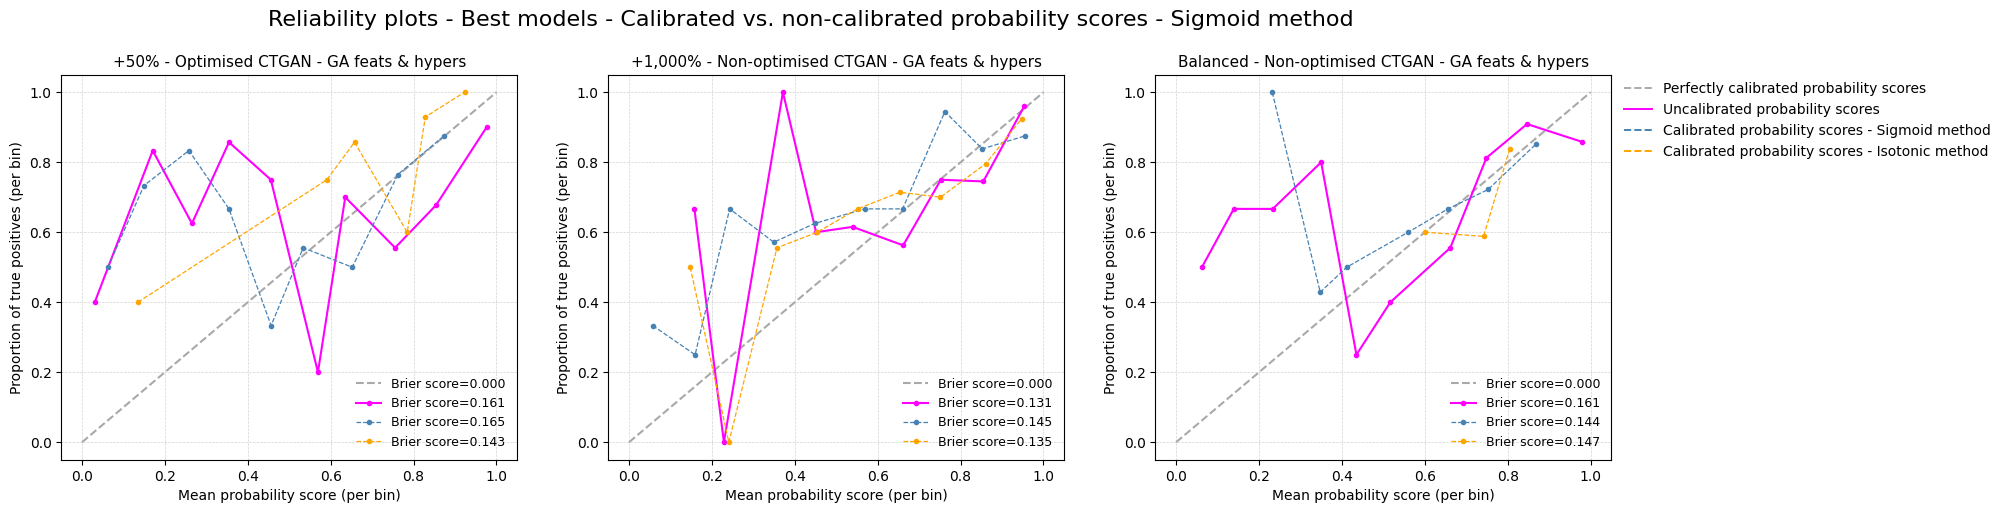

In [ ]:
##### Set up plot(s) #####

# Set up subplots
fig, axes=plt.subplots(1,3,figsize=(20,5),gridspec_kw={'hspace': 0.5})

# Over-arching title of all plots
fig.suptitle('Reliability plots - Best models - Calibrated vs. non-calibrated probability scores - Sigmoid method', fontsize=16, y=1.01)

#################### +50 model ####################

##### Get GA feats & GA hypers #####
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o','rb') as file:
    hypers=pickle.load(file)

##### Get non-optimised training data & hold out data #####
x_train, y_train, x_test, y_test, _=data_prep('_50','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get uncalibrated probability scores #####
model=lgb.LGBMClassifier(**hypers)
model.set_params(verbose=-1)
model.fit(x_train[feats], y_train)
y_pred_uncal_50=model.predict_proba(x_test[feats])[:, 1]

##### Get recalibrated probability scores using CV method #####
model1=lgb.LGBMClassifier(**hypers)
model1.set_params(verbose=-1)
# Sigmoid
cal_model_sig=CalibratedClassifierCV(model1, method='sigmoid', ensemble=False, cv=10)
cal_model_sig.fit(x_train[feats], y_train)
y_pred_cal_sig_50=cal_model_sig.predict_proba(x_test[feats])[:, 1]
# Isotonic1
cal_model_iso=CalibratedClassifierCV(model1, method='isotonic', ensemble=False, cv=10)
cal_model_iso.fit(x_train[feats], y_train)
y_pred_cal_iso_50=cal_model_iso.predict_proba(x_test[feats])[:, 1]

##### Calculate Brier scores #####
brier_uncalibrated=brier_score_loss(y_test,y_pred_uncal_50)
brier_calibrated_sig=brier_score_loss(y_test,y_pred_cal_sig_50)
brier_calibrated_iso=brier_score_loss(y_test,y_pred_cal_iso_50)

##### Create reliability plots #####
# Get 'fraction of actuals' (foa) & 'mean probability value' (mvp)
foa_uncalibrated,   mpv_uncalibrated    =calibration_curve(y_test, y_pred_uncal_50,   n_bins=10, strategy='uniform')
foa_calibrated_sig, mpv_calibrated_sig  =calibration_curve(y_test, y_pred_cal_sig_50, n_bins=10, strategy='uniform')
foa_calibrated_iso, mpv_calibrated_iso  =calibration_curve(y_test, y_pred_cal_iso_50, n_bins=10, strategy='uniform')

# Plot perfectly calibrated line
axes[0].plot([0, 1], [0, 1], linestyle='--', color='darkgray', label='Brier score=0.000')
# Plot model reliabilities
axes[0].plot(mpv_uncalibrated,    foa_uncalibrated,   marker='.', color='magenta',                             label=f'Brier score={brier_uncalibrated:.3f}')
axes[0].plot(mpv_calibrated_sig,  foa_calibrated_sig, marker='.', color='steelblue',  linestyle='--',  lw=0.9, label=f'Brier score={brier_calibrated_sig:.3f}')
axes[0].plot(mpv_calibrated_iso,  foa_calibrated_iso, marker='.', color='orange',     linestyle='--',  lw=0.9, label=f'Brier score={brier_calibrated_iso:.3f}')
axes[0].set_title('+50% - Optimised CTGAN - GA feats & hypers', fontsize=11)
axes[0].set_xlabel('Mean probability score (per bin)',fontsize=10)
axes[0].set_ylabel('Proportion of true positives (per bin)',fontsize=10)
axes[0].tick_params(labelsize=10)
axes[0].legend(frameon=False, loc='lower right', fontsize=9)
axes[0].grid(color='lightgray', linestyle='--', linewidth=0.5)

#################### +1,000 model ####################

##### Get GA feats & GA hypers #####
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000','rb') as file:
    hypers=pickle.load(file)

##### Get non-optimised training data & hold out data #####
x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get uncalibrated probability scores #####
model=lgb.LGBMClassifier(**hypers)
model.set_params(verbose=-1)
model.fit(x_train[feats], y_train)
y_pred_uncal_1000=model.predict_proba(x_test[feats])[:, 1]

##### Get recalibrated probability scores using CV method (default cv=5) #####
model1=lgb.LGBMClassifier(**hypers)
model1.set_params(verbose=-1)
# Sigmoid
cal_model_sig=CalibratedClassifierCV(model1)
cal_model_sig.fit(x_train[feats], y_train)
y_pred_cal_sig_1000=cal_model_sig.predict_proba(x_test[feats])[:, 1]
# Isotonic
cal_model_iso=CalibratedClassifierCV(model1, method='isotonic',cv=8)
cal_model_iso.fit(x_train[feats], y_train)
y_pred_cal_iso_1000=cal_model_iso.predict_proba(x_test[feats])[:, 1]

##### Calculate Brier scores #####
brier_uncalibrated=brier_score_loss(y_test,y_pred_uncal_1000)
brier_calibrated_sig=brier_score_loss(y_test,y_pred_cal_sig_1000)
brier_calibrated_iso=brier_score_loss(y_test,y_pred_cal_iso_1000)

##### Create reliability plots #####
# Get 'fraction of actuals' (foa) & 'mean probability value' (mvp)
foa_uncalibrated,   mpv_uncalibrated    = calibration_curve(y_test, y_pred_uncal_1000,    n_bins=10, strategy='uniform')
foa_calibrated_sig, mpv_calibrated_sig  = calibration_curve(y_test, y_pred_cal_sig_1000,  n_bins=10, strategy='uniform')
foa_calibrated_iso, mpv_calibrated_iso  = calibration_curve(y_test, y_pred_cal_iso_1000,  n_bins=10, strategy='uniform')
# Plot perfectly calibrated line
axes[1].plot([0, 1], [0, 1], linestyle='--', color='darkgray', label='Brier score=0.000')
# Plot model reliabilities
axes[1].plot(mpv_uncalibrated,    foa_uncalibrated,   marker='.', color='magenta',                              label=f'Brier score={brier_uncalibrated:.3f}')
axes[1].plot(mpv_calibrated_sig,  foa_calibrated_sig, marker='.', color='steelblue',  linestyle='--',  lw=0.9, label=f'Brier score={brier_calibrated_sig:.3f}')
axes[1].plot(mpv_calibrated_iso,  foa_calibrated_iso, marker='.', color='orange',     linestyle='--',  lw=0.9, label=f'Brier score={brier_calibrated_iso:.3f}')
axes[1].set_title('+1,000% - Non-optimised CTGAN - GA feats & hypers', fontsize=11)
axes[1].set_xlabel('Mean probability score (per bin)',fontsize=10)
axes[1].set_ylabel('Proportion of true positives (per bin)',fontsize=10)
axes[1].tick_params(labelsize=10)
axes[1].legend(frameon=False,loc='lower right',fontsize=9)
axes[1].grid(color='lightgray', linestyle='--', linewidth=0.5)

#################### Balanced model ####################

##### Get non-optimised training data & hold out data #####
x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get feats (all) & hypers (defaults) #####

feats=list(x_train.columns)
default_model=lgb.LGBMClassifier()
hypers=default_model.get_params()

##### Get uncalibrated probability scores #####
model=lgb.LGBMClassifier(**hypers)
model.set_params(verbose=-1)
model.fit(x_train[feats], y_train)
y_pred_uncal_bal=model.predict_proba(x_test[feats])[:, 1]

##### Get recalibrated probability scores using CV method #####
model1=lgb.LGBMClassifier(**hypers)
model1.set_params(verbose=-1)
# Sigmoid
cal_model_sig=CalibratedClassifierCV(model1, ensemble=True)
cal_model_sig.fit(x_train[feats], y_train)
y_pred_cal_sig_bal=cal_model_sig.predict_proba(x_test[feats])[:, 1]
# Isotonic
cal_model_iso=CalibratedClassifierCV(model1, method='isotonic', ensemble=False, cv=7)
cal_model_iso.fit(x_train[feats], y_train)
y_pred_cal_iso_bal=cal_model_iso.predict_proba(x_test[feats])[:, 1]

##### Calculate Brier scores ####
brier_uncalibrated=brier_score_loss(y_test,y_pred_uncal_bal)
brier_calibrated_sig=brier_score_loss(y_test,y_pred_cal_sig_bal)
brier_calibrated_iso=brier_score_loss(y_test,y_pred_cal_iso_bal)

##### Create reliability plots #####
# Get 'fraction of actuals' (foa) & 'mean probability value' (mvp)
foa_uncalibrated,     mpv_uncalibrated      = calibration_curve(y_test, y_pred_uncal_bal,     n_bins=10, strategy='uniform')
foa_calibrated_sig,   mpv_calibrated_sig    = calibration_curve(y_test, y_pred_cal_sig_bal,   n_bins=10, strategy='uniform')
foa_calibrated_iso,   mpv_calibrated_iso    = calibration_curve(y_test, y_pred_cal_iso_bal,   n_bins=10, strategy='uniform')
# Plot perfectly calibrated line
line1, =axes[2].plot([0, 1], [0, 1], linestyle='--', color='darkgray', label='Brier score=0.000')
# Plot model reliabilities
line2, =axes[2].plot(mpv_uncalibrated,    foa_uncalibrated,   marker='.', color='magenta',                             label=f'Brier score={brier_uncalibrated:.3f}')
line3, =axes[2].plot(mpv_calibrated_sig,  foa_calibrated_sig, marker='.', color='steelblue',  linestyle='--', lw=0.9, label=f'Brier score={brier_calibrated_sig:.3f}')
line4, =axes[2].plot(mpv_calibrated_iso,  foa_calibrated_iso, marker='.', color='orange',     linestyle='--', lw=0.9, label=f'Brier score={brier_calibrated_iso:.3f}')
axes[2].set_title('Balanced - Non-optimised CTGAN - GA feats & hypers', fontsize=11)
axes[2].set_xlabel('Mean probability score (per bin)',fontsize=10)
axes[2].set_ylabel('Proportion of true positives (per bin)',fontsize=10)
axes[2].tick_params(labelsize=10)
axes[2].legend(frameon=False,loc='lower right',fontsize=9)
axes[2].grid(color='lightgray', linestyle='--', linewidth=0.5)

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Perfectly calibrated probability scores'),
                       Line2D([0], [0], color=line2.get_color(), linestyle=line2.get_linestyle(), lw=1.4, label='Uncalibrated probability scores'),
                       Line2D([0], [0], color=line3.get_color(), linestyle=line3.get_linestyle(), lw=1.4, label='Calibrated probability scores - Sigmoid method'),
                       Line2D([0], [0], color=line4.get_color(), linestyle=line4.get_linestyle(), lw=1.4, label='Calibrated probability scores - Isotonic method')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.90, 0.89), loc='upper left', frameon=False)

plt.show()

Some of the recalibrated curves are better than the uncalibrated curve. The Brier scores can be infleunced by outliers so may not reflect the improvement. Here choose:

- +50% model - Sigmoid recalibration as the curve is an improvement and Isotonic method maybe overfitting due the small level of samples (1,140) where the recommended minimum is 1,000

- +1,000 model - Isotonic recalibration as the curve is an improvement and the sample size is significant (7,600) versus the recommended minimum of 1,000

- Balanced - Use sigmoid due to small sampel size (760) and better curve than that of uncalibrated and isotonic with the latter overfitting


##### **6.5.2. Show changes in distribution of probability scores post-calibration**

Show distribution stats

In [ ]:
# Bring probability scores together
all_50= {'Uncalibrated':          y_pred_uncal_50,
         'Calibrated-Sigmoid':    y_pred_cal_sig_50,
         'Calibrated-Isotonic':   y_pred_cal_iso_50}
all_50_df=pd.DataFrame(all_50)

all_1000={'Uncalibrated':         y_pred_uncal_1000,
          'Calibrated-Sigmoid':   y_pred_cal_sig_1000,
          'Calibrated-Isotonic':  y_pred_cal_iso_1000}
all_1000_df=pd.DataFrame(all_1000)

all_bal={'Uncalibrated':          y_pred_uncal_bal,
         'Calibrated-Sigmoid':    y_pred_cal_sig_bal,
         'Calibrated-Isotonic':   y_pred_cal_iso_bal}
all_bal_df=pd.DataFrame(all_bal)

In [ ]:
# Get distribution statistics
all_50_a=all_50_df.Uncalibrated.describe()
all_50_b=all_50_df['Calibrated-Sigmoid'].describe()
all_50_c=all_50_df['Calibrated-Isotonic'].describe()
all_50_all={'50-Uncal':        all_50_a,
            '50-Cal-Sig':  all_50_b,
            '50-Cal-Iso': all_50_c}
all_50_all_df=pd.DataFrame(all_50_all)[2:]

all_1000_a=all_1000_df.Uncalibrated.describe()
all_1000_b=all_1000_df['Calibrated-Sigmoid'].describe()
all_1000_c=all_1000_df['Calibrated-Isotonic'].describe()
all_1000_all={'1000:Uncal':        all_1000_a,
              '1000:Cal-Sig':  all_1000_b,
              '1000:Cal-Iso': all_1000_c}
all_1000_all_df=pd.DataFrame(all_1000_all)[2:]


all_bal_a=all_bal_df.Uncalibrated.describe()
all_bal_b=all_bal_df['Calibrated-Sigmoid'].describe()
all_bal_c=all_bal_df['Calibrated-Isotonic'].describe()
all_bal_all={'Bal:Uncal':        all_bal_a,
             'Bal:Cal-Sig':  all_bal_b,
             'Bal:Cal-Iso': all_bal_c}
all_bal_all_df=pd.DataFrame(all_bal_all)[2:]


In [ ]:
all_df=pd.concat([all_50_all_df, all_1000_all_df, all_bal_all_df], axis=1)
all_df

,50-Uncal,50-Cal-Sig,50-Cal-Iso,1000:Uncal,1000:Cal-Sig,1000:Cal-Iso,Bal:Uncal,Bal:Cal-Sig,Bal:Cal-Iso
std,0.24,0.23,0.11,0.19,0.20,0.18,0.22,0.13,0.03
min,0.02,0.05,0.11,0.11,0.05,0.11,0.05,0.21,0.60
25%,0.85,0.79,0.79,0.75,0.83,0.76,0.85,0.85,0.80
50%,0.97,0.87,0.81,0.89,0.85,0.90,0.97,0.87,0.80
75%,0.99,0.89,0.81,0.95,0.90,0.95,0.99,0.88,0.81
max,1.00,0.89,0.92,1.00,1.00,0.99,1.00,0.88,0.82


Remember:
- The probability scores are derived from the unbalanced test data and so will be centred around 0.80
- The prior for BC is 0.79 (our dataset was oddly skewed to the event of interest) so the recalibration has definately brought the uncalibrated scores down to be closer to the prior

Show distribution plots

Version 1

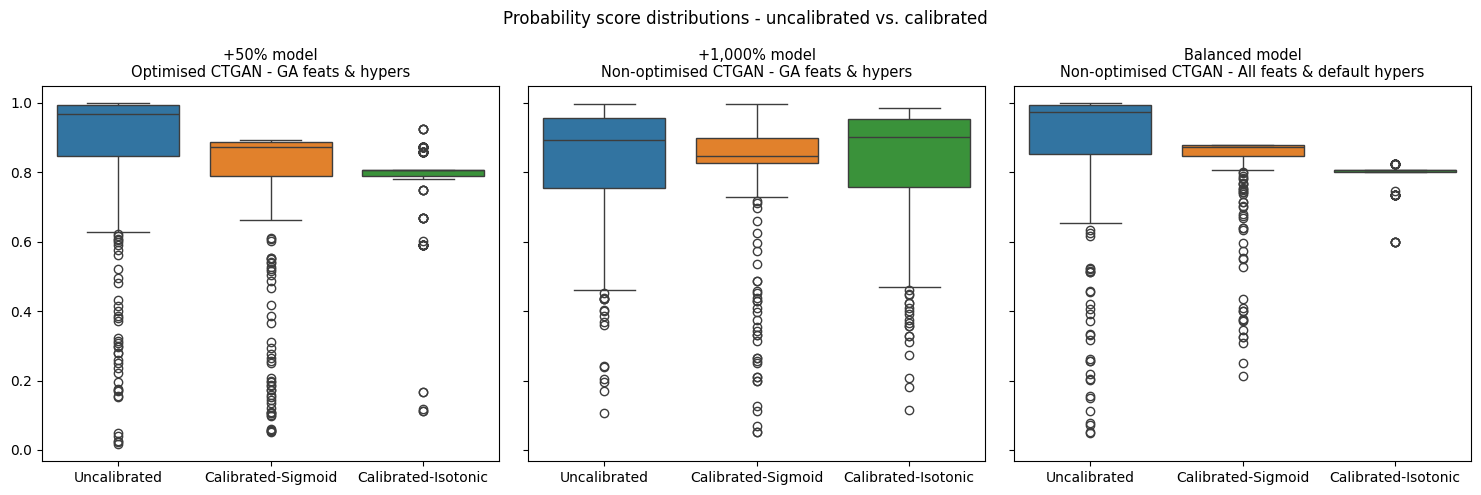

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot boxplots for each DataFrame
sns.boxplot(data=all_50_df,   ax=axes[0])
axes[0].set_title('+50% model\nOptimised CTGAN - GA feats & hypers', fontsize=10.5)
sns.boxplot(data=all_1000_df, ax=axes[1])
axes[1].set_title('+1,000% model\nNon-optimised CTGAN - GA feats & hypers', fontsize=10.5)
sns.boxplot(data=all_bal_df,  ax=axes[2])
axes[2].set_title('Balanced model\nNon-optimised CTGAN - All feats & default hypers', fontsize=10.5)

# Add labels and title to the overall plot
fig.suptitle('Probability score distributions - uncalibrated vs. calibrated')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Version 2

Excluded Isotonic method from balanced model due to sample size (760) being less than 1,000

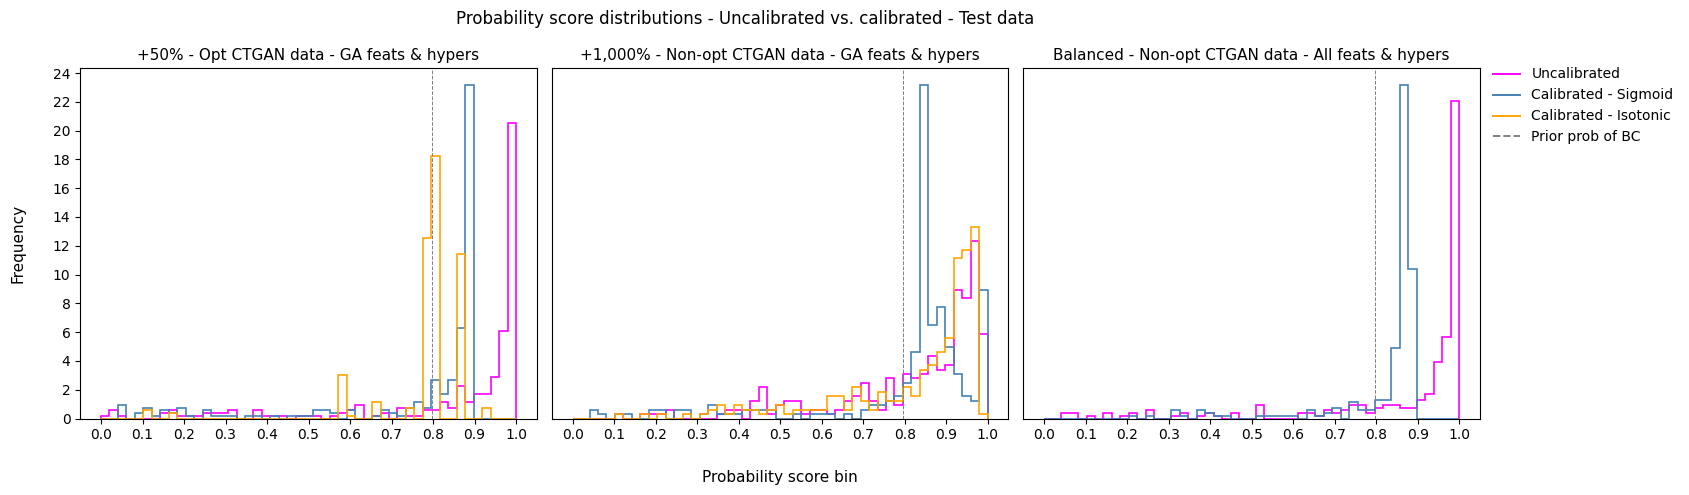

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create the bins
bins = np.linspace(0, 1, 50)

# Plot histograms
fig.suptitle('Probability score distributions - Uncalibrated vs. calibrated - Test data', fontsize=12)

axes[0].hist(all_50_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0].hist(all_50_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0].hist(all_50_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticks(np.arange(0, 26, 2))
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('+50% - Opt CTGAN data - GA feats & hypers', fontsize=11)

_, bins, _ =axes[1].hist(all_1000_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
_, bins, _ =axes[1].hist(all_1000_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
_, bins, _ =axes[1].hist(all_1000_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_yticks([])
axes[1].set_xlabel('Probability score bin',fontsize=11)
axes[1].set_title('+1,000% - Non-opt CTGAN data - GA feats & hypers', fontsize=11)

axes[2].hist(all_bal_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[2].hist(all_bal_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[2].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].set_yticks([])
axes[2].set_title('Balanced - Non-opt CTGAN data - All feats & hypers', fontsize=11)

# Add line for prior probability score (training dataset)

axes[0].axvline(x=0.797, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1].axvline(x=0.797, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
line1=axes[2].axvline(x=0.797, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')

# Add extra legend
extra_legend_elements=[Line2D([0], [0], color='magenta', linestyle='-', lw=1.4, label='Uncalibrated'),
                       Line2D([0], [0], color='steelblue', linestyle='-', lw=1.4, label='Calibrated - Sigmoid'),
                       Line2D([0], [0], color='orange', linestyle='-', lw=1.4, label='Calibrated - Isotonic'),
                       Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Prior prob of BC')]
fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.99, 0.89), loc='upper left', frameon=False, fontsize=10)

axes[1].xaxis.labelpad = 20
axes[0].yaxis.labelpad = 20

plt.tight_layout()
plt.show()

##### **6.5.3. Recalculate threshold-variant performance metrics** **bold text**

**+50% model**

In [ ]:
##### Get GA feats & GA hypers ####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o','rb') as file:
    hypers=pickle.load(file)

##### Get optimised training data & hold out data #####

x_train, y_train, x_test, y_test, _=data_prep('_50_o','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Repeat the build process to get probability scores #####

y_pred=y_pred_cal_sig_50

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_50_o_cal.pkl')
# Download performance metrics
threshold_analysis_50_o_cal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_50_o_cal.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.171
4. Best ROC curve threshold : 0.86
5. Maximising F1 score threshold : 0.884
6. Bal SS threshold : 0.86
7. Perf score similarity - Tsai : 0.845
8. Perf score similarity - Shih : 0.86


In [ ]:
threshold_analysis_50_o_cal

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.90,0.84,0.23,0.87,0.78,0.95,0.78
1,prior pop prob,0.80,0.80,0.88,0.49,0.83,0.74,0.95,0.78
2,"closest pt on pr curve to [1,1]",0.17,0.96,0.83,0.13,0.89,0.81,0.95,0.78
3,maximise f1 score,0.88,0.46,0.98,0.96,0.63,0.55,0.95,0.78
4,perf metrics similarity - tsai,0.84,0.72,0.93,0.74,0.81,0.72,0.95,0.78
5,"closest pt on roc curve to [0,1], balance sens...",0.86,0.68,0.95,0.83,0.79,0.71,0.95,0.78


In [ ]:
# Compared to threshold analysis of non-calibrated probability scores
threshold_analysis_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_50_o.pkl')
threshold_analysis_50_o

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.90,0.83,0.19,0.87,0.77,0.95,0.78
1,prior pop prob,0.80,0.84,0.87,0.43,0.85,0.76,0.95,0.78
2,"closest pt on pr curve to [1,1]",0.28,0.96,0.83,0.13,0.89,0.81,0.95,0.78
3,maximise f1 score,0.99,0.46,0.99,0.98,0.63,0.55,0.95,0.78
4,perf metrics similarity - tsai,0.92,0.72,0.93,0.74,0.81,0.72,0.95,0.78
5,perf metrics similarity - shih,0.94,0.68,0.95,0.83,0.79,0.71,0.95,0.78
6,"closest pt on roc curve to [0,1], balance sens...",0.94,0.67,0.95,0.83,0.79,0.70,0.95,0.78


**+1,000% model**

In [ ]:
##### Get GA feats & GA hypers ####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000','rb') as file:
    feats=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000','rb') as file:
    hypers=pickle.load(file)

##### Get optimised training data & hold out data #####

x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Repeat the build process to get probability scores #####

y_pred=y_pred_cal_iso_1000

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_1000_cal.pkl')
# Download performance metrics
threshold_analysis_1000_cal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_1000_cal.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.476
4. Best ROC curve threshold : 0.859
5. Maximising F1 score threshold : 0.949
6. Bal SS threshold : 0.859
7. Perf score similarity - Tsai : 0.856
8. Perf score similarity - Shih : 0.859


In [ ]:
threshold_analysis_1000_cal

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.94,0.85,0.23,0.89,0.81,0.94,0.76
1,prior pop prob,0.80,0.78,0.88,0.53,0.83,0.73,0.94,0.76
2,"closest pt on pr curve to [1,1]",0.48,0.96,0.85,0.23,0.90,0.83,0.94,0.76
3,maximise f1 score,0.95,0.34,0.99,0.98,0.51,0.46,0.94,0.76
4,perf metrics similarity - tsai,0.86,0.71,0.92,0.72,0.80,0.71,0.94,0.76
5,"closest pt on roc curve to [0,1], balance sens...",0.86,0.70,0.93,0.74,0.80,0.71,0.94,0.76


In [ ]:
# Compared to threshold analysis of non-calibrated probability scores
threshold_analysis_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_1000.pkl')
threshold_analysis_1000

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.93,0.84,0.21,0.89,0.80,0.95,0.79
1,prior pop prob,0.80,0.77,0.90,0.62,0.83,0.74,0.95,0.79
2,"closest pt on pr curve to [1,1]",0.52,0.92,0.85,0.28,0.89,0.81,0.95,0.79
3,"closest pt on roc curve to [0,1]",0.84,0.69,0.92,0.74,0.79,0.70,0.95,0.79
4,maximise f1 score,0.93,0.47,0.98,0.96,0.64,0.56,0.95,0.79
5,balance sensitivity & specificity,0.87,0.65,0.93,0.79,0.77,0.68,0.95,0.79
6,perf metrics similarity - tsai,0.78,0.79,0.90,0.62,0.84,0.76,0.95,0.79
7,perf metrics similarity - shih,0.84,0.69,0.92,0.74,0.79,0.70,0.95,0.79


**Balanced model**

In [ ]:
##### Get non-optimised training data & hold out data #####
x_train, y_train, x_test, y_test, _=data_prep('_1000','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl','/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

##### Get feats (all) & hypers (defaults) #####

feats=list(x_train.columns)
default_model=lgb.LGBMClassifier()
hypers=default_model.get_params()

##### Repeat the build process to get probability scores #####

y_pred=y_pred_cal_sig_bal

##### Calculate performance metrics for 1,000 thresholds between 0 & 1 #####

metrics_df=perf_metrics(y_pred,y_test)

##### Identify custom thresholds #####

# 1. Maximum probability
max_prob_threshold=round(0.5,3)

# 2. Prior probability
prior_prob_threshold=round(0.796646,3)

# 3. Point on PR-curve closest to [1,1] by finding minimum Euclidean distance for all points on curve
precision, recall, thresholds=precision_recall_curve(y_test,y_pred)
idx1=np.argmin(np.sqrt((recall-1)**2+(precision-1)**2))
pr_opt_threshold=round(thresholds[idx1],3)

# 4. Point on ROC-curve closest to [0,1] by finding minimum Euclidean distance for all points on curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
idx3=np.argmin(np.sqrt((fpr-0)**2 + (tpr-1)**2))
roc_opt_threshold=round(thresholds[idx3],3)

# 5. Balancing precision & recall by finding maximum f1 score
f1_scores=f1_scores_array(precision, recall)
idx2=np.argmax(f1_scores)
max_f1_threshold=round(thresholds[idx2],3)

# 6. Balancing sensitivity & specificity
gmeans=np.sqrt(tpr*(1-fpr))
idx4=np.argmax(gmeans)
ss_bal_threshold=round(thresholds[idx4],3)

# 7. Performance metrics similarity to Tsai
metrics_df['eucl_dist_tsai'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.876,0.863,0.877,0.895,0.855,0.932])
idx5=metrics_df['eucl_dist_tsai'].idxmin()
tsai_threshold=round(metrics_df.loc[idx5]['threshold'],3)

# 8. Performance metrics similarity to Shih
metrics_df['eucl_dist_shih'] = metrics_df[['accuracy','precision','f1','recall','specificity','roc_auc']].apply(euclidean_distance1, axis=1, given_point=[0.8903,0.9485,0.8762,0.8230,0.9597,0.9200])
idx6=metrics_df['eucl_dist_shih'].idxmin()
shih_threshold=round(metrics_df.loc[idx6]['threshold'],3)

# Output threshold values
print('1. Max prob score threshold :',       max_prob_threshold)
print('2. Prior prob threshold :',           prior_prob_threshold)
print('3. Best PR curve threshold :',        pr_opt_threshold)
print('4. Best ROC curve threshold :',       roc_opt_threshold)
print('5. Maximising F1 score threshold :',  max_f1_threshold)
print('6. Bal SS threshold :',               ss_bal_threshold)
print('7. Perf score similarity - Tsai :',   tsai_threshold)
print('8. Perf score similarity - Shih :',   shih_threshold)

##### Subset metrics_df to performance metrics using custom thresholds #####

threshold_values=[pr_opt_threshold,max_f1_threshold,roc_opt_threshold,ss_bal_threshold,max_prob_threshold,tsai_threshold,shih_threshold,prior_prob_threshold]
threshold_values_df=pd.DataFrame({'threshold':threshold_values,'flag':1})
metrics_df.threshold=round(metrics_df.threshold,3)
metrics_df1=pd.merge(metrics_df, threshold_values_df, on='threshold', how='inner').drop(columns=['flag'],axis=1).reset_index(drop=True)
metrics_df1['threshold_method']=metrics_df1.apply(get_threshold_methods,axis=1).astype('str')
metrics_df1['threshold_method']=metrics_df1['threshold_method'].str.replace('(', '').str.replace(')', '').str.replace("'", '').str.rstrip(',')
metrics_df2=metrics_df1[['threshold_method', 'threshold',	'recall',	'precision',	'specificity',	'f1',	'accuracy',	'pr_auc',	'roc_auc']].drop_duplicates()
custom_row_order=['max prob score','prior pop prob','closest pt on pr curve to [1,1]','closest pt on roc curve to [0,1]','maximise f1 score','balance sensitivity & specificity','perf metrics similarity - tsai','perf metrics similarity - shih']
metrics_df3=metrics_df2.sort_values(by='threshold_method',key=lambda x:x.map({v:i for i, v in enumerate(custom_row_order)})).reset_index(drop=True)

# Save performance metrics
metrics_df3.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_bal_cal.pkl')
# Download performance metrics
threshold_analysis_bal_cal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_bal_cal.pkl')

1. Max prob score threshold : 0.5
2. Prior prob threshold : 0.797
3. Best PR curve threshold : 0.668
4. Best ROC curve threshold : 0.868
5. Maximising F1 score threshold : 1.879
6. Bal SS threshold : 0.868
7. Perf score similarity - Tsai : 0.856
8. Perf score similarity - Shih : 0.868


In [ ]:
threshold_analysis_bal_cal

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.97,0.83,0.13,0.89,0.81,0.87,0.63
1,prior pop prob,0.80,0.88,0.85,0.30,0.86,0.77,0.87,0.63
2,"closest pt on pr curve to [1,1]",0.67,0.94,0.84,0.21,0.89,0.81,0.87,0.63
3,perf metrics similarity - tsai,0.86,0.74,0.87,0.49,0.80,0.70,0.87,0.63
4,"closest pt on roc curve to [0,1], balance sens...",0.87,0.66,0.87,0.57,0.75,0.64,0.87,0.63


In [ ]:
# Compared to threshold analysis of non-calibrated probability scores
threshold_analysis_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/threshold_analysis_bal.pkl')
threshold_analysis_bal

,threshold_method,threshold,recall,precision,specificity,f1,accuracy,pr_auc,roc_auc
0,max prob score,0.50,0.94,0.84,0.19,0.89,0.80,0.87,0.62
1,prior pop prob,0.80,0.84,0.86,0.40,0.85,0.76,0.87,0.62
2,"closest pt on pr curve to [1,1]",0.69,0.91,0.86,0.34,0.89,0.81,0.87,0.62
3,maximise f1 score,1.00,0.05,1.00,1.00,0.10,0.22,0.87,0.62
4,perf metrics similarity - tsai,0.76,0.87,0.87,0.40,0.87,0.79,0.87,0.62
5,perf metrics similarity - shih,0.95,0.65,0.87,0.55,0.75,0.64,0.87,0.62
6,"closest pt on roc curve to [0,1], balance sens...",0.95,0.65,0.87,0.55,0.75,0.64,0.87,0.62
